<a href="https://colab.research.google.com/github/lognamin/Predicting-Cargo-Theft/blob/main/Regression_and_Classification_Analysis_Cargo_Theft_FBI_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Getting the dataset

import os
from six.moves import urllib
import zipfile

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics

# Info:
# https://crime-data-explorer.fr.cloud.gov/pages/downloads
# Cargo Theft

DOWNLOAD_URL = 'https://s3-us-gov-west-1.amazonaws.com/cg-d4b776d0-d898-4153-90c8-8336f86bdfec/CT_2013_2020.zip'
DATA_PATH = os.path.join("datasets", "cargo_theft")
FILENAME = 'cargo_theft.zip'

def fetch_data(download_url=DOWNLOAD_URL, data_path=DATA_PATH, filename=FILENAME):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    file_path = os.path.join(data_path, filename)
    urllib.request.urlretrieve(download_url, file_path)
    file_zip = zipfile.ZipFile(file_path)
    file_zip.extractall(path=data_path)

    
fetch_data()

In [ ]:
import pandas as pd

FILENAME = 'CT_2013_2020.csv'

def load_data(data_path=DATA_PATH, filename=FILENAME):
    file_path = os.path.join(data_path, filename)
    return pd.read_csv(file_path)

master = load_data()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# Classification

## Classification - Method 2

In [ ]:
cargo = load_data()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
# What the data looks like.
cargo.head()

,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,COUNTY_NAME,REGION_NAME,POPULATION_GROUP_CODE,POPULATION_GROUP_DESC,OFFENSE_CODE,OFFENSE_NAME,OFFENDER_RACE,OFFENDER_ETHNICITY,OFFENDER_AGE,OFFENDER_SEX,VICTIM_TYPE_CODE,VICTIM_TYPE_NAME,LOCATION_CODE,LOCATION_NAME,WEAPON_CODE,WEAPON_NAME,PROP_DESC_ID,PROP_DESC_CODE,PROP_DESC_NAME,STOLEN_VALUE,RECOVERED_VALUE,RECOVERED_FLAG,DATE_RECOVERED
0,2020,TN0940100,Franklin,NaN,City,TN,Tennessee,East South Central,WILLIAMSON,South,3,"Cities from 50,000 thru 99,999",23D,Theft From Building,NaN,NaN,NaN,NaN,G,Government,50,Park/Playground,NaN,NaN,61.0,75.0,Portable Electronic Communications,3000.0,0.0,N,NaN
1,2019,NC0340100,Kernersville,NaN,City,NC,North Carolina,South Atlantic,GUILFORD; FORSYTH,South,5,"Cities from 10,000 thru 24,999",23D,Theft From Building,Unknown,Unknown,NaN,U,I,Individual,20,Residence/Home,NaN,NaN,25.0,25.0,Purse/ Wallet,50.0,0.0,N,NaN
2,2019,NC0240500,Whiteville,NaN,City,NC,North Carolina,South Atlantic,COLUMBUS,South,6,"Cities from 2,500 thru 9,999",23D,Theft From Building,Unknown,Unknown,NaN,U,I,Individual,20,Residence/Home,NaN,NaN,16.0,16.0,Household Goods,950.0,0.0,N,NaN
3,2012,TN0191700,Tennessee State University,NaN,University or College,TN,Tennessee,East South Central,NaN,South,7,"Cities under 2,500",23D,Theft From Building,Unknown,NaN,NaN,U,I,Individual,21,Restaurant,NaN,NaN,61.0,75.0,Portable Electronic Communications,250.0,0.0,N,NaN
4,2012,TN0191700,Tennessee State University,NaN,University or College,TN,Tennessee,East South Central,NaN,South,7,"Cities under 2,500",23D,Theft From Building,Unknown,NaN,NaN,U,I,Individual,20,Residence/Home,NaN,NaN,61.0,75.0,Portable Electronic Communications,150.0,0.0,N,NaN


In [ ]:
# Most of the data is categorical and there are missing values.
cargo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131419 entries, 0 to 131418
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DATA_YEAR              131419 non-null  int64  
 1   ORI                    131419 non-null  object 
 2   PUB_AGENCY_NAME        131419 non-null  object 
 3   PUB_AGENCY_UNIT        1470 non-null    object 
 4   AGENCY_TYPE_NAME       131419 non-null  object 
 5   STATE_ABBR             131419 non-null  object 
 6   STATE_NAME             131419 non-null  object 
 7   DIVISION_NAME          131419 non-null  object 
 8   COUNTY_NAME            130727 non-null  object 
 9   REGION_NAME            131419 non-null  object 
 10  POPULATION_GROUP_CODE  131419 non-null  object 
 11  POPULATION_GROUP_DESC  131419 non-null  object 
 12  OFFENSE_CODE           131419 non-null  object 
 13  OFFENSE_NAME           131419 non-null  object 
 14  OFFENDER_RACE          73631 non-nul

In [ ]:
# A glance at the data.
cargo.describe(include='all')

,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,COUNTY_NAME,REGION_NAME,POPULATION_GROUP_CODE,POPULATION_GROUP_DESC,OFFENSE_CODE,OFFENSE_NAME,OFFENDER_RACE,OFFENDER_ETHNICITY,OFFENDER_AGE,OFFENDER_SEX,VICTIM_TYPE_CODE,VICTIM_TYPE_NAME,LOCATION_CODE,LOCATION_NAME,WEAPON_CODE,WEAPON_NAME,PROP_DESC_ID,PROP_DESC_CODE,PROP_DESC_NAME,STOLEN_VALUE,RECOVERED_VALUE,RECOVERED_FLAG,DATE_RECOVERED
count,131419.000000,131419,131419,1470,131419,131419,131419,131419,130727,131419,131419,131419,131419,131419,73631,42475,51924.000000,73632,131419,131419,131419.000000,131419,13197,13197,131348.000000,131348.000000,131348,1.312060e+05,1.294620e+05,131348,19069
unique,NaN,3098,2371,131,7,46,46,9,1016,4,18,18,40,40,6,3,NaN,3,9,9,NaN,46,21,18,NaN,NaN,68,NaN,NaN,2,2379
top,NaN,TNMPD0000,Memphis,Keyser,City,NC,North Carolina,South Atlantic,SHELBY,South,4,"Cities from 25,000 thru 49,999",23F,Theft From Motor Vehicle,White,Not Hispanic or Latino,NaN,M,I,Individual,NaN,Residence/Home,12,Handgun,NaN,NaN,Other,NaN,NaN,N,09-SEP-20
freq,NaN,4941,4941,146,90041,29305,29305,59189,6088,83985,15465,15465,32532,32532,30401,23947,NaN,44037,96114,96114,NaN,51285,4728,4730,NaN,NaN,21467,NaN,NaN,112299,199
mean,2017.150275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.911775,NaN,NaN,NaN,18.612126,NaN,NaN,NaN,30.393443,34.321794,NaN,1.742586e+04,1.559566e+03,NaN,NaN
std,2.619831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.323555,NaN,NaN,NaN,8.457626,NaN,NaN,NaN,21.463021,27.230609,NaN,2.870407e+06,1.991621e+04,NaN,NaN
min,2011.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,0.000000e+00,0.000000e+00,NaN,NaN
25%,2015.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.000000,NaN,NaN,NaN,13.000000,NaN,NaN,NaN,12.000000,12.000000,NaN,2.000000e+01,0.000000e+00,NaN,NaN
50%,2018.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,24.000000,24.000000,NaN,2.200000e+02,0.000000e+00,NaN,NaN
75%,2019.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,52.000000,66.000000,NaN,1.019000e+03,0.000000e+00,NaN,NaN


In [ ]:
# Look at the data a bit more deeply, escpecially for the categorical variables.
# NOTE: The target 'RECOVERED_FLAG' has a N to Y ratio of about 6:1.
for col in cargo.columns:
    print(cargo[col].value_counts())
    print('----')

2020    31145
2019    29184
2016    17572
2012    12201
2015    10983
2017    10440
2014     8261
2018     7970
2013     3640
2011       23
Name: DATA_YEAR, dtype: int64
----
TNMPD0000    4941
NC0600100    3934
MA0031100    3159
OHCLP0000    2796
MD0160400    2256
             ... 
AR0080200       1
SC0021400       1
WI0440200       1
WA0171200       1
SD0170000       1
Name: ORI, Length: 3098, dtype: int64
----
Memphis                                4941
Charlotte-Mecklenburg                  3934
New Bedford                            3159
Cleveland                              2852
Montgomery County Police Department    2256
                                       ... 
Reno                                      1
Hampshire                                 1
Brown                                     1
Bainbridge Island                         1
Keyser                                    1
Name: PUB_AGENCY_NAME, Length: 2371, dtype: int64
----
Keyser               146
New Castle County   

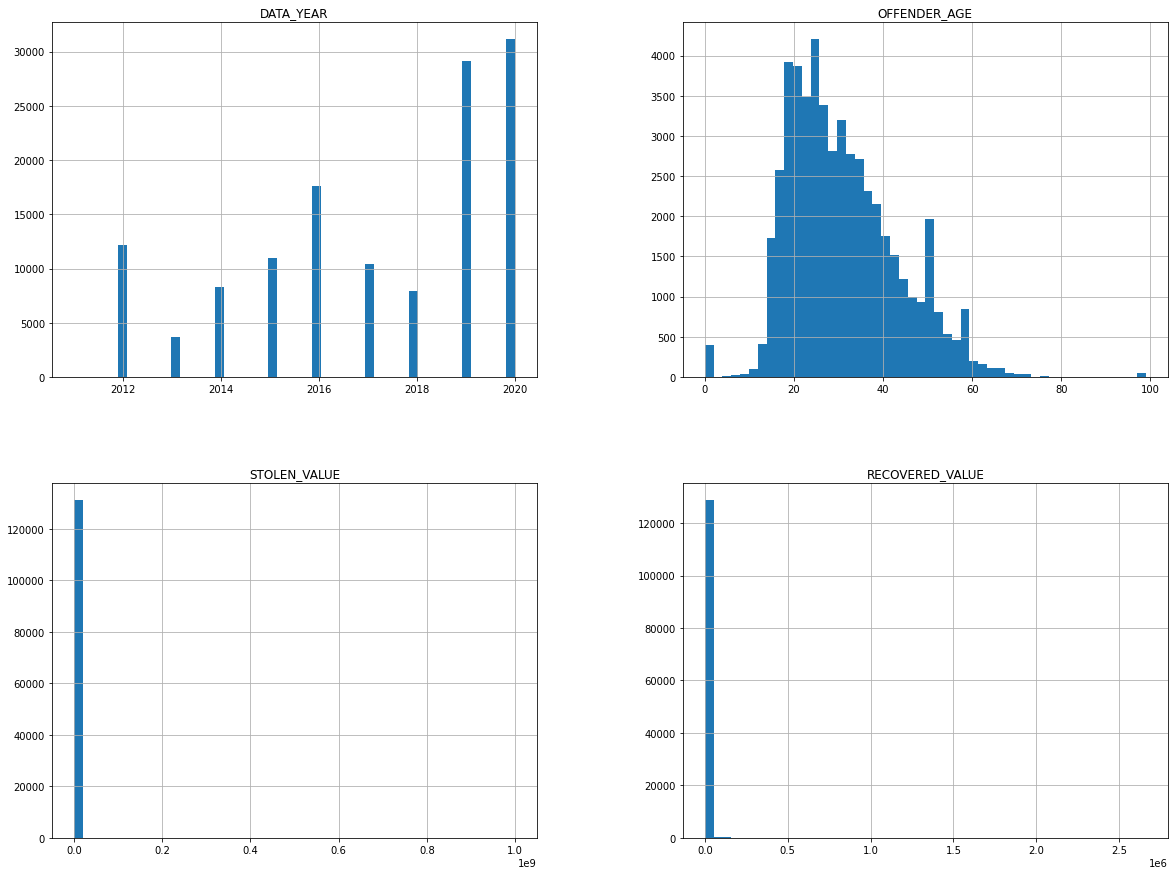

In [ ]:
# Plot the only numerical features that have meaning.
cargo.hist(bins=50, column=['DATA_YEAR','OFFENDER_AGE','STOLEN_VALUE','RECOVERED_VALUE'], figsize=(20,15))
plt.show()

In [ ]:
# Drop the 71 rows that don't have a RECOVERED_FLAG value.
cargo_valid_flag = cargo.loc[cargo['RECOVERED_FLAG'].notna()].copy()

cargo_valid_flag['RECOVERED_FLAG'].isna().any()

False

In [ ]:
# Drop columns that either have too many categorical variables (~ >100),
# are redundant (like _CODE that has the same info as _NAME),
# and RECOVERED columns that give RECOVERED_FLAG almost by default.
drop_cols = ['ORI', 'PUB_AGENCY_NAME', 'PUB_AGENCY_UNIT',
             'STATE_ABBR', 'COUNTY_NAME',
             'POPULATION_GROUP_CODE', 'OFFENSE_CODE',
             'VICTIM_TYPE_CODE', 'LOCATION_CODE',
             'WEAPON_CODE', 'PROP_DESC_ID', 'PROP_DESC_CODE', 'DATE_RECOVERED',
             'RECOVERED_VALUE']
cargo_selected_cols = cargo_valid_flag.drop(columns=drop_cols)

cargo_selected_cols.head()

,DATA_YEAR,AGENCY_TYPE_NAME,STATE_NAME,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_DESC,OFFENSE_NAME,OFFENDER_RACE,OFFENDER_ETHNICITY,OFFENDER_AGE,OFFENDER_SEX,VICTIM_TYPE_NAME,LOCATION_NAME,WEAPON_NAME,PROP_DESC_NAME,STOLEN_VALUE,RECOVERED_FLAG
0,2020,City,Tennessee,East South Central,South,"Cities from 50,000 thru 99,999",Theft From Building,NaN,NaN,NaN,NaN,Government,Park/Playground,NaN,Portable Electronic Communications,3000.0,N
1,2019,City,North Carolina,South Atlantic,South,"Cities from 10,000 thru 24,999",Theft From Building,Unknown,Unknown,NaN,U,Individual,Residence/Home,NaN,Purse/ Wallet,50.0,N
2,2019,City,North Carolina,South Atlantic,South,"Cities from 2,500 thru 9,999",Theft From Building,Unknown,Unknown,NaN,U,Individual,Residence/Home,NaN,Household Goods,950.0,N
3,2012,University or College,Tennessee,East South Central,South,"Cities under 2,500",Theft From Building,Unknown,NaN,NaN,U,Individual,Restaurant,NaN,Portable Electronic Communications,250.0,N
4,2012,University or College,Tennessee,East South Central,South,"Cities under 2,500",Theft From Building,Unknown,NaN,NaN,U,Individual,Residence/Home,NaN,Portable Electronic Communications,150.0,N


In [ ]:
# Change 'RECOVERED_FLAG' from Y/N string to 1/0 number.
cargo_flag_num = cargo_selected_cols.copy()
cargo_flag_num['RECOVERED_FLAG'] = cargo_flag_num['RECOVERED_FLAG'].replace('N','0',regex=True)
cargo_flag_num['RECOVERED_FLAG'] = cargo_flag_num['RECOVERED_FLAG'].replace('Y','1',regex=True)
cargo_flag_num['RECOVERED_FLAG'] = pd.to_numeric(cargo_flag_num['RECOVERED_FLAG'],errors = 'coerce')

cargo_flag_num['RECOVERED_FLAG'].value_counts()

0    112299
1     19049
Name: RECOVERED_FLAG, dtype: int64

In [ ]:
# We are going to be looking at filling empty values and correlation,
# so first split the data to not be influenced by the test set.

# Use stratified because the target is ~6:1 not recovered to recovered.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(cargo_flag_num, cargo_flag_num['RECOVERED_FLAG']):
    cargo_train = cargo_flag_num.iloc[train_index]
    cargo_test = cargo_flag_num.iloc[test_index]

In [ ]:
# Check that the ratio is preserved and that the size of the split is correct.
print(cargo_train['RECOVERED_FLAG'].value_counts())
print(cargo_test['RECOVERED_FLAG'].value_counts())
print('----')
print('Original ratio - {}'.format(cargo_flag_num['RECOVERED_FLAG'].value_counts()[0]/cargo_flag_num['RECOVERED_FLAG'].value_counts()[1]))
print('Train ratio    - {}'.format(cargo_train['RECOVERED_FLAG'].value_counts()[0]/cargo_train['RECOVERED_FLAG'].value_counts()[1]))
print('Test ratio     - {}'.format(cargo_test['RECOVERED_FLAG'].value_counts()[0]/cargo_test['RECOVERED_FLAG'].value_counts()[1]))
print('----')
print('Test size - {}'.format(len(cargo_test)/len(cargo_flag_num)))

0    89839
1    15239
Name: RECOVERED_FLAG, dtype: int64
0    22460
1     3810
Name: RECOVERED_FLAG, dtype: int64
----
Original ratio - 5.895270092918263
Train ratio    - 5.895334339523591
Test ratio     - 5.89501312335958
----
Test size - 0.20000304534518987


In [ ]:
# Which columns have empty values?
# Note: Looking at the data before the split to make sure we aren't missing
#       any columns due to the split.
cargo_flag_num.isna().any()

DATA_YEAR                False
AGENCY_TYPE_NAME         False
STATE_NAME               False
DIVISION_NAME            False
REGION_NAME              False
POPULATION_GROUP_DESC    False
OFFENSE_NAME             False
OFFENDER_RACE             True
OFFENDER_ETHNICITY        True
OFFENDER_AGE              True
OFFENDER_SEX              True
VICTIM_TYPE_NAME         False
LOCATION_NAME            False
WEAPON_NAME               True
PROP_DESC_NAME           False
STOLEN_VALUE              True
RECOVERED_FLAG           False
dtype: bool

In [ ]:
# Look at the columns that need imputing.
# Some have an "unknown" value already, so that can be used for the missing values in those columns.
for col in ['OFFENDER_RACE', 'OFFENDER_ETHNICITY', 'OFFENDER_AGE', 'OFFENDER_SEX', 'WEAPON_NAME', 'STOLEN_VALUE']:
    print(cargo_train[col].value_counts())
    print('----')

White                                        24334
Black or African American                    17645
Unknown                                      16164
American Indian or Alaska Native               525
Asian                                          140
Native Hawaiian or Other Pacific Islander        3
Name: OFFENDER_RACE, dtype: int64
----
Not Hispanic or Latino    19257
Unknown                   12382
Hispanic or Latino         2462
Name: OFFENDER_ETHNICITY, dtype: int64
----
25.0    1834
18.0    1660
20.0    1561
24.0    1529
30.0    1513
        ... 
5.0        2
87.0       1
91.0       1
77.0       1
78.0       1
Name: OFFENDER_AGE, Length: 81, dtype: int64
----
M    35210
U    14479
F     9123
Name: OFFENDER_SEX, dtype: int64
----
Handgun                     3738
Personal Weapons            2333
None                        1070
Knife/Cutting Instrument     621
Firearm                      603
Other                        410
Unknown                      379
Handgun (Automatic) 

In [ ]:
# Fill with the mode or with the "unknown" value if it exists.
# Note: Using the mode from the train values to also fill the test set.
fill_values = {
    'OFFENDER_RACE': 'Unknown',
    'OFFENDER_ETHNICITY': 'Unknown',
    'OFFENDER_AGE': cargo_train['OFFENDER_AGE'].mode().iloc[0],
    'OFFENDER_SEX': 'U',
    'WEAPON_NAME': 'Unknown',
    'STOLEN_VALUE':cargo_train['STOLEN_VALUE'].mode().iloc[0]
}
cargo_filled_train = cargo_train.fillna(value=fill_values)
cargo_filled_test = cargo_test.fillna(value=fill_values)

print(cargo_filled_train.isna().any())
print(cargo_filled_test.isna().any())

DATA_YEAR                False
AGENCY_TYPE_NAME         False
STATE_NAME               False
DIVISION_NAME            False
REGION_NAME              False
POPULATION_GROUP_DESC    False
OFFENSE_NAME             False
OFFENDER_RACE            False
OFFENDER_ETHNICITY       False
OFFENDER_AGE             False
OFFENDER_SEX             False
VICTIM_TYPE_NAME         False
LOCATION_NAME            False
WEAPON_NAME              False
PROP_DESC_NAME           False
STOLEN_VALUE             False
RECOVERED_FLAG           False
dtype: bool
DATA_YEAR                False
AGENCY_TYPE_NAME         False
STATE_NAME               False
DIVISION_NAME            False
REGION_NAME              False
POPULATION_GROUP_DESC    False
OFFENSE_NAME             False
OFFENDER_RACE            False
OFFENDER_ETHNICITY       False
OFFENDER_AGE             False
OFFENDER_SEX             False
VICTIM_TYPE_NAME         False
LOCATION_NAME            False
WEAPON_NAME              False
PROP_DESC_NAME           Fa

In [ ]:
# Check that the "NaN" values are no longer visible.
cargo_filled_train.head()

,DATA_YEAR,AGENCY_TYPE_NAME,STATE_NAME,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_DESC,OFFENSE_NAME,OFFENDER_RACE,OFFENDER_ETHNICITY,OFFENDER_AGE,OFFENDER_SEX,VICTIM_TYPE_NAME,LOCATION_NAME,WEAPON_NAME,PROP_DESC_NAME,STOLEN_VALUE,RECOVERED_FLAG
89195,2019,City,Ohio,East North Central,Midwest,"Cities from 25,000 thru 49,999",Burglary/Breaking & Entering,Unknown,Unknown,25.0,U,Individual,Residence/Home,Unknown,Recreational/ Sports Equipment,1550.0,0
19673,2019,County,North Carolina,South Atlantic,South,"Non-MSA counties from 25,000 thru 99,999",Burglary/Breaking & Entering,Unknown,Unknown,25.0,U,Business,Department/Discount Store,Unknown,Merchandise,3069.0,0
46317,2012,County,Florida,South Atlantic,South,"MSA counties 100,000 or over",Motor Vehicle Theft,Unknown,Unknown,25.0,U,Business,Other/Unknown,Unknown,Automobile,134000.0,0
6498,2017,City,Tennessee,East South Central,South,"Cities from 50,000 thru 99,999",All Other Larceny,Unknown,Unknown,25.0,U,Individual,Parking/Drop Lot/Garage,Unknown,Portable Electronic Communications,900.0,0
102597,2015,County,Virginia,South Atlantic,South,"MSA counties from 25,000 thru 99,999",Destruction/Damage/Vandalism of Property,Unknown,Unknown,25.0,U,Business,Construction Site,Unknown,Tools,1195.0,0


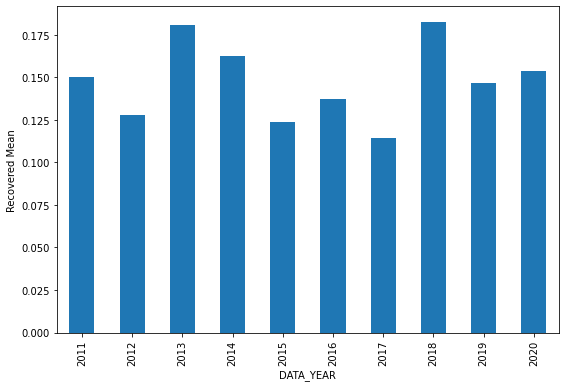

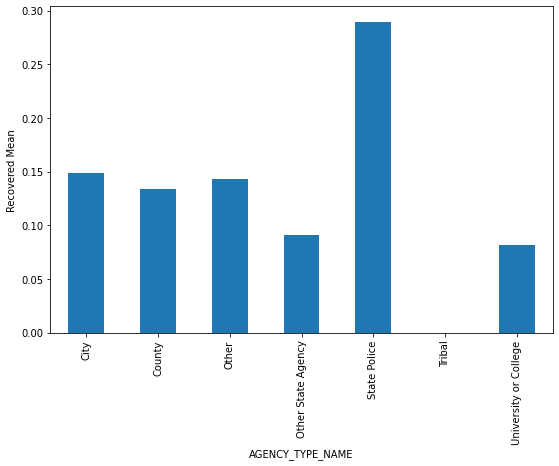

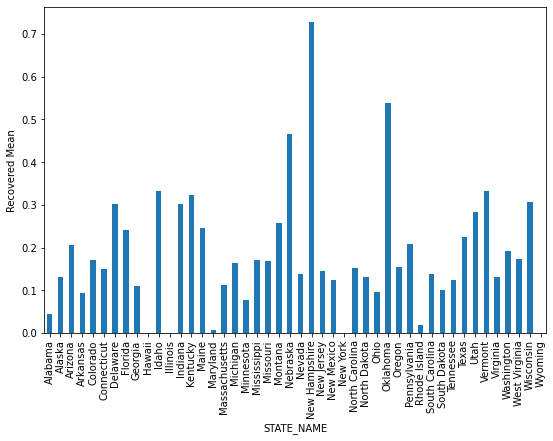

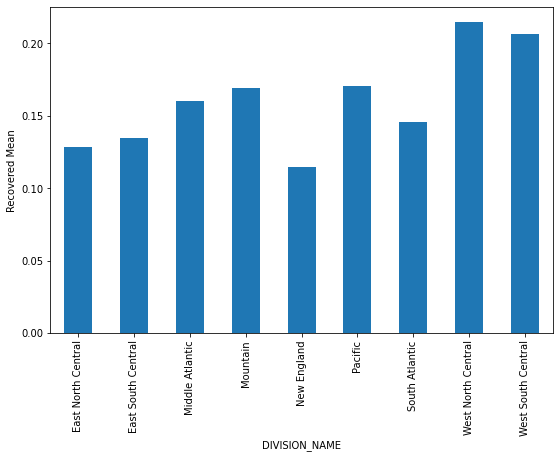

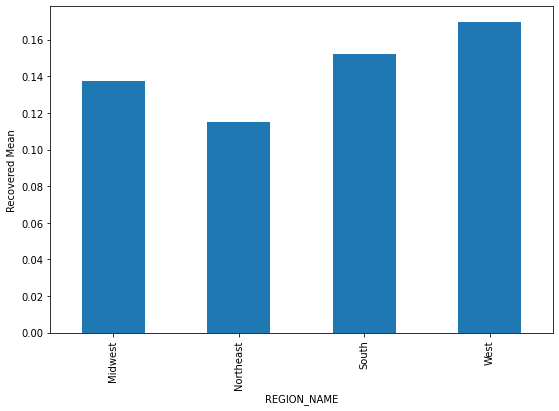

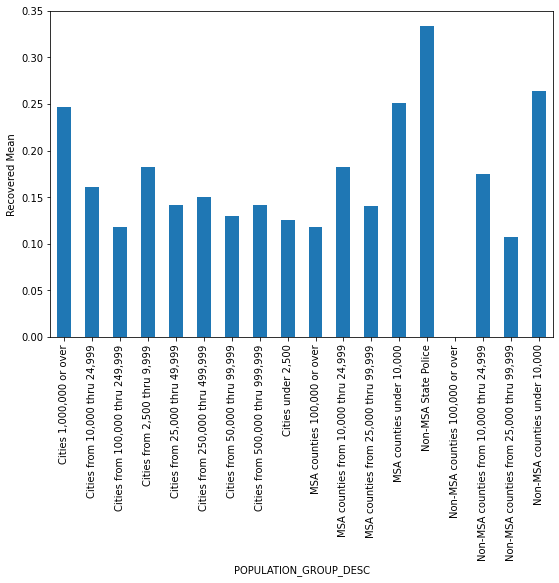

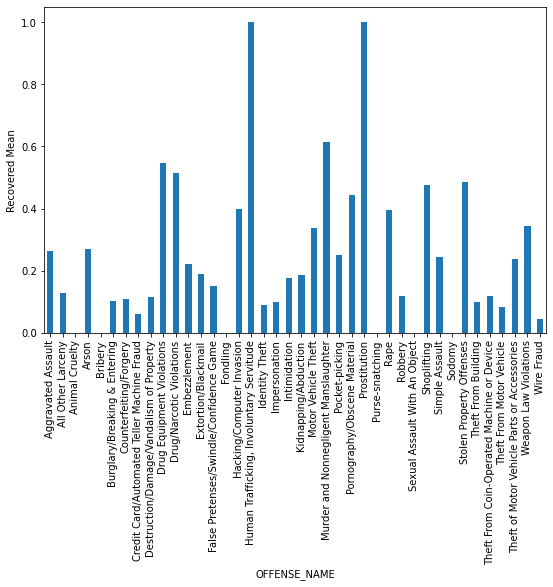

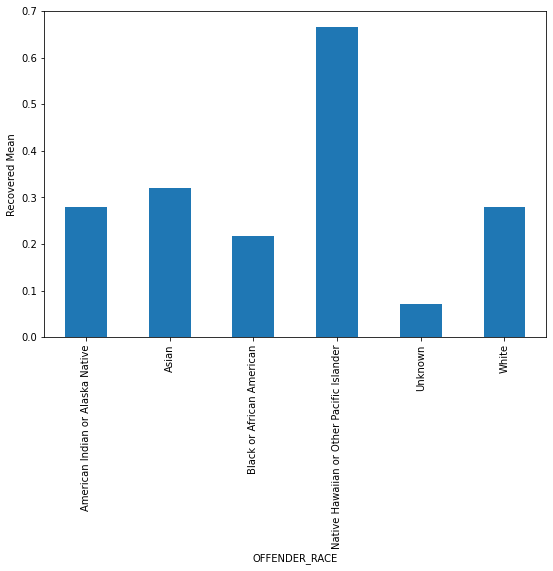

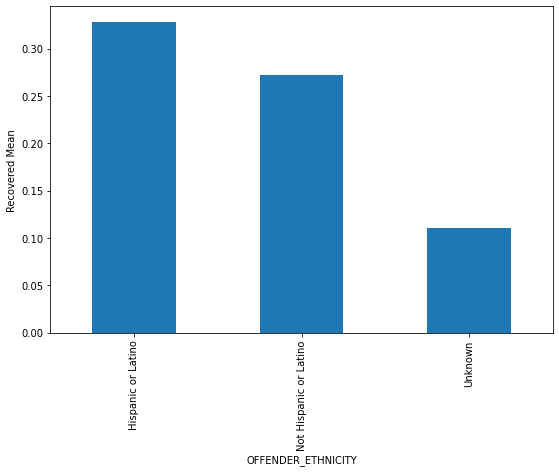

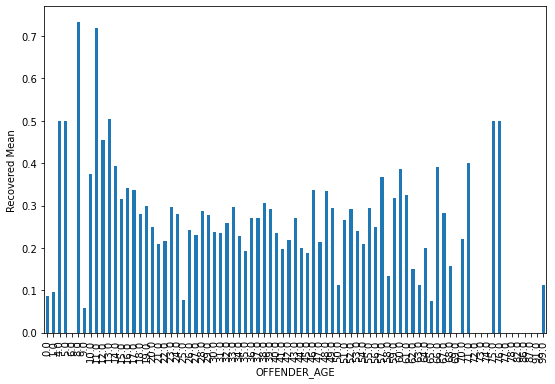

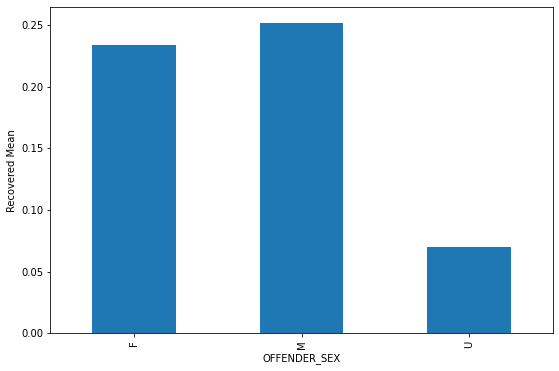

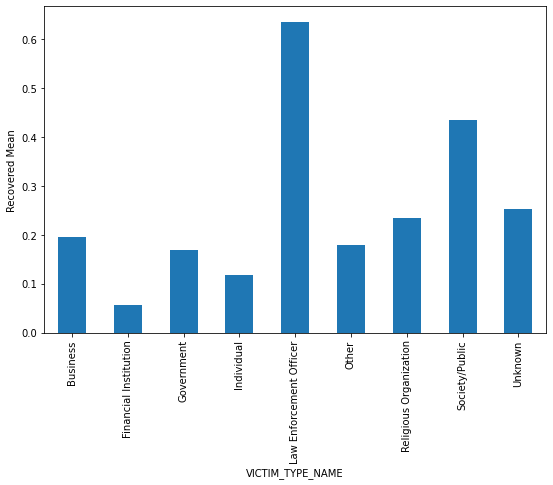

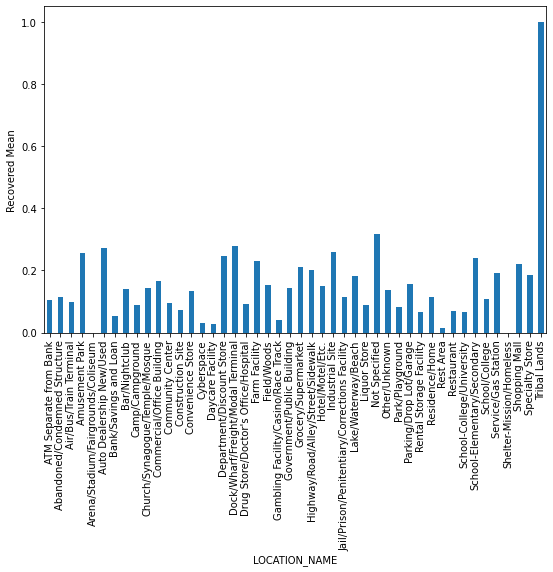

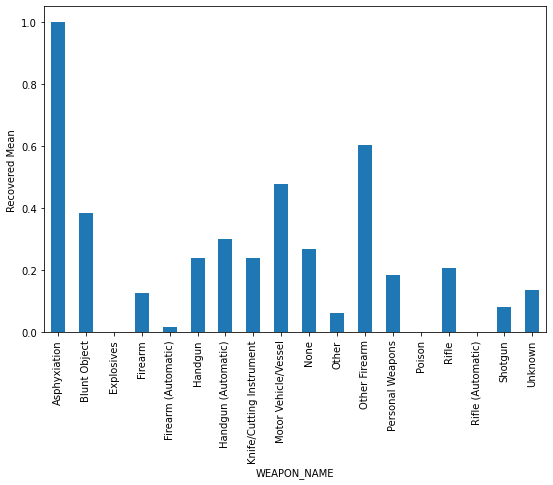

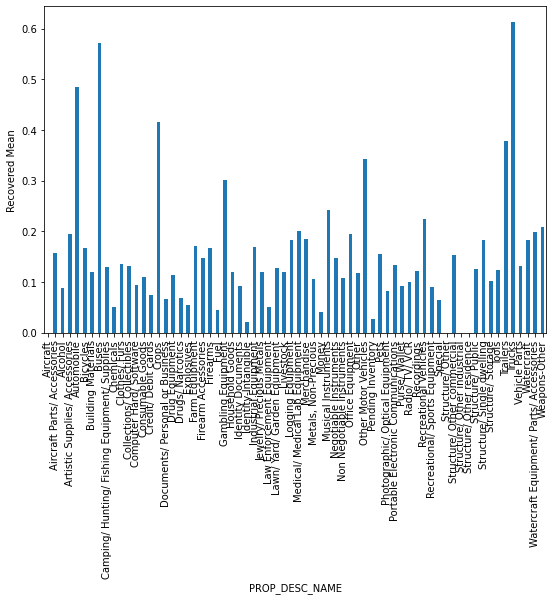

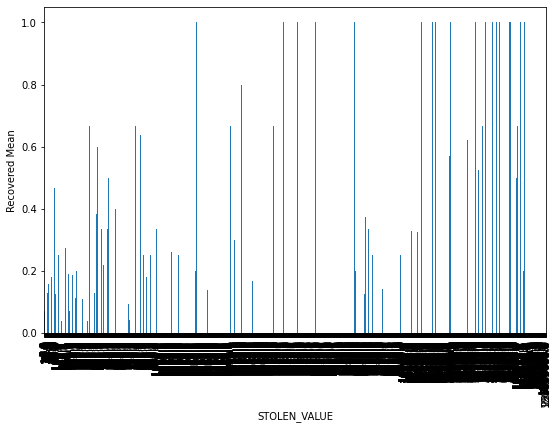

In [ ]:
# Since the target is 1/0 (Y/N), as a sort of correlation,
# plot the different feature values vs average recovered flag to see if some values are more inportant than others.
for col in cargo_filled_train.columns:
    if col == 'RECOVERED_FLAG':
        continue
    to_plot = cargo_filled_train.groupby(col)['RECOVERED_FLAG'].mean()
    plt.figure()
    to_plot.plot(kind='bar', ylabel='Recovered Mean', xlabel=col, figsize=(9,6))
    plt.show()

In [ ]:
# Remove columns that have less that 0.5 difference between their highest value and lowest value.
drop_cols_from_correlation = ['DATA_YEAR', 'AGENCY_TYPE_NAME', 'DIVISION_NAME', 'REGION_NAME', 'POPULATION_GROUP_DESC', 'OFFENDER_ETHNICITY', 'OFFENDER_SEX']

cargo_important_train = cargo_filled_train.drop(columns=drop_cols_from_correlation)
cargo_important_test = cargo_filled_test.drop(columns=drop_cols_from_correlation)

cargo_important_train.head()

,STATE_NAME,OFFENSE_NAME,OFFENDER_RACE,OFFENDER_AGE,VICTIM_TYPE_NAME,LOCATION_NAME,WEAPON_NAME,PROP_DESC_NAME,STOLEN_VALUE,RECOVERED_FLAG
89195,Ohio,Burglary/Breaking & Entering,Unknown,25.0,Individual,Residence/Home,Unknown,Recreational/ Sports Equipment,1550.0,0
19673,North Carolina,Burglary/Breaking & Entering,Unknown,25.0,Business,Department/Discount Store,Unknown,Merchandise,3069.0,0
46317,Florida,Motor Vehicle Theft,Unknown,25.0,Business,Other/Unknown,Unknown,Automobile,134000.0,0
6498,Tennessee,All Other Larceny,Unknown,25.0,Individual,Parking/Drop Lot/Garage,Unknown,Portable Electronic Communications,900.0,0
102597,Virginia,Destruction/Damage/Vandalism of Property,Unknown,25.0,Business,Construction Site,Unknown,Tools,1195.0,0


In [ ]:
# Normalize the Age and Value columns that will be much bigger than the other 1s and 0s otherwise.
cargo_norm_train = cargo_important_train.copy()
cargo_norm_test = cargo_important_test.copy()

# Use a Standard scaler because Age is somewhat gaussian and Value has extreme values (close to min/max).
scaler = StandardScaler()
# Fit only with training data and then transform both training and test.
# Some manipulation needed to get this working.
scaler.fit(cargo_norm_train['OFFENDER_AGE'].values.reshape(-1,1))
cargo_norm_train['OFFENDER_AGE'] = scaler.transform(cargo_important_train['OFFENDER_AGE'].values.reshape(-1,1))
cargo_norm_test['OFFENDER_AGE'] = scaler.transform(cargo_important_test['OFFENDER_AGE'].values.reshape(-1,1))
# Repeat.
scaler = StandardScaler()
scaler.fit(cargo_norm_train['STOLEN_VALUE'].values.reshape(-1,1))
cargo_norm_train['STOLEN_VALUE'] = scaler.transform(cargo_important_train['STOLEN_VALUE'].values.reshape(-1,1))
cargo_norm_test['STOLEN_VALUE'] = scaler.transform(cargo_important_test['STOLEN_VALUE'].values.reshape(-1,1))

cargo_norm_train.head()

,STATE_NAME,OFFENSE_NAME,OFFENDER_RACE,OFFENDER_AGE,VICTIM_TYPE_NAME,LOCATION_NAME,WEAPON_NAME,PROP_DESC_NAME,STOLEN_VALUE,RECOVERED_FLAG
89195,Ohio,Burglary/Breaking & Entering,Unknown,-0.28258,Individual,Residence/Home,Unknown,Recreational/ Sports Equipment,-0.005709,0
19673,North Carolina,Burglary/Breaking & Entering,Unknown,-0.28258,Business,Department/Discount Store,Unknown,Merchandise,-0.005235,0
46317,Florida,Motor Vehicle Theft,Unknown,-0.28258,Business,Other/Unknown,Unknown,Automobile,0.035611,0
6498,Tennessee,All Other Larceny,Unknown,-0.28258,Individual,Parking/Drop Lot/Garage,Unknown,Portable Electronic Communications,-0.005912,0
102597,Virginia,Destruction/Damage/Vandalism of Property,Unknown,-0.28258,Business,Construction Site,Unknown,Tools,-0.005819,0


In [ ]:
# Change categorical columns to dummy / one hots and drop the original ones.
cat_cols = ['STATE_NAME', 'OFFENSE_NAME', 'OFFENDER_RACE', 'VICTIM_TYPE_NAME',
            'LOCATION_NAME', 'WEAPON_NAME', 'PROP_DESC_NAME']
cargo_dummied_train = cargo_norm_train.copy()
cargo_dummied_test = cargo_norm_test.copy()
for col in cat_cols:
    # Train side.
    one_hot = pd.get_dummies(cargo_norm_train[col], prefix=col)
    cargo_dummied_train = cargo_dummied_train.drop(columns=col)
    cargo_dummied_train = cargo_dummied_train.join(one_hot)
    # Test side.
    one_hot = pd.get_dummies(cargo_norm_test[col], prefix=col)
    cargo_dummied_test = cargo_dummied_test.drop(columns=col)
    cargo_dummied_test = cargo_dummied_test.join(one_hot)
    

cargo_dummied_train.head()

,OFFENDER_AGE,STOLEN_VALUE,RECOVERED_FLAG,STATE_NAME_Alabama,STATE_NAME_Alaska,STATE_NAME_Arizona,STATE_NAME_Arkansas,STATE_NAME_Colorado,STATE_NAME_Connecticut,STATE_NAME_Delaware,STATE_NAME_Florida,STATE_NAME_Georgia,STATE_NAME_Hawaii,STATE_NAME_Idaho,STATE_NAME_Illinois,STATE_NAME_Indiana,STATE_NAME_Kentucky,STATE_NAME_Maine,STATE_NAME_Maryland,STATE_NAME_Massachusetts,STATE_NAME_Michigan,STATE_NAME_Minnesota,STATE_NAME_Mississippi,STATE_NAME_Missouri,STATE_NAME_Montana,STATE_NAME_Nebraska,STATE_NAME_Nevada,STATE_NAME_New Hampshire,STATE_NAME_New Jersey,STATE_NAME_New Mexico,STATE_NAME_New York,STATE_NAME_North Carolina,STATE_NAME_North Dakota,STATE_NAME_Ohio,STATE_NAME_Oklahoma,STATE_NAME_Oregon,STATE_NAME_Pennsylvania,STATE_NAME_Rhode Island,STATE_NAME_South Carolina,STATE_NAME_South Dakota,...,PROP_DESC_NAME_Industrial Equipment,PROP_DESC_NAME_Jewelry/ Precious Metals,PROP_DESC_NAME_Law Enforcement Equipment,PROP_DESC_NAME_Lawn/ Yard/ Garden Equipment,PROP_DESC_NAME_Livestock,PROP_DESC_NAME_Logging Equipment,PROP_DESC_NAME_Medical/ Medical Lab Equipment,PROP_DESC_NAME_Merchandise,"PROP_DESC_NAME_Metals, Non-Precious",PROP_DESC_NAME_Money,PROP_DESC_NAME_Musical Instruments,PROP_DESC_NAME_Negotiable Instruments,PROP_DESC_NAME_Non Negotiable Instruments,PROP_DESC_NAME_Office Equipment,PROP_DESC_NAME_Other,PROP_DESC_NAME_Other Motor Vehicles,PROP_DESC_NAME_Pending Inventory,PROP_DESC_NAME_Pets,PROP_DESC_NAME_Photographic/ Optical Equipment,PROP_DESC_NAME_Portable Electronic Communications,PROP_DESC_NAME_Purse/ Wallet,PROP_DESC_NAME_Radio/ TV/ VCR,PROP_DESC_NAME_Recordings,PROP_DESC_NAME_Recreational Vehicles,PROP_DESC_NAME_Recreational/ Sports Equipment,PROP_DESC_NAME_Special,PROP_DESC_NAME_Structure/ Other,PROP_DESC_NAME_Structure/ Other commercial,PROP_DESC_NAME_Structure/ Other industrial,PROP_DESC_NAME_Structure/ Other residence,PROP_DESC_NAME_Structure/ Public,PROP_DESC_NAME_Structure/ Single dwelling,PROP_DESC_NAME_Structure/ Storage,PROP_DESC_NAME_Tools,PROP_DESC_NAME_Trailers,PROP_DESC_NAME_Trucks,PROP_DESC_NAME_Vehicle Parts,PROP_DESC_NAME_Watercraft,PROP_DESC_NAME_Watercraft Equipment/ Parts/ Accessories,PROP_DESC_NAME_Weapons-Other
89195,-0.28258,-0.005709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19673,-0.28258,-0.005235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46317,-0.28258,0.035611,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6498,-0.28258,-0.005912,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102597,-0.28258,-0.005819,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
print('Train shape and test shape.\nAfter dummies.')
print(cargo_dummied_train.shape)
print(cargo_dummied_test.shape)
print('----')

# Because dummies were done on different sets of data, if one is missing a value, it won't show up as a column.
# This can cause errors in prediction because the columns don't match.
# Add in the missing columns from each to both.
cargo_assign_train = cargo_dummied_train.copy()
cargo_assign_test = cargo_dummied_test.copy()
print('Test missing:')
for col in cargo_dummied_train.columns:
    if col not in cargo_dummied_test.columns:
        print(col)
        # Normally using col=0 will add a new column called "col".
        # Create a dict and unpack it with ** so the name in the col variable will be used instead.
        cargo_assign_test = cargo_assign_test.assign(**{col: 0})
print('----')
print('Train missing:')
for col in cargo_dummied_test.columns:
    if col not in cargo_dummied_train.columns:
        print(col)
        cargo_assign_train = cargo_assign_train.assign(**{col: 0})

print('----')
print('After assign.')
print(cargo_assign_train.shape)
print(cargo_assign_test.shape)

cargo_assign_train.head()

Train shape and test shape.
After dummies.
(105078, 236)
(26270, 231)
----
Test missing:
STATE_NAME_Wyoming
OFFENSE_NAME_Bribery
OFFENSE_NAME_Sexual Assault With An Object
OFFENSE_NAME_Sodomy
WEAPON_NAME_Poison
----
Train missing:
----
After assign.
(105078, 236)
(26270, 236)


,OFFENDER_AGE,STOLEN_VALUE,RECOVERED_FLAG,STATE_NAME_Alabama,STATE_NAME_Alaska,STATE_NAME_Arizona,STATE_NAME_Arkansas,STATE_NAME_Colorado,STATE_NAME_Connecticut,STATE_NAME_Delaware,STATE_NAME_Florida,STATE_NAME_Georgia,STATE_NAME_Hawaii,STATE_NAME_Idaho,STATE_NAME_Illinois,STATE_NAME_Indiana,STATE_NAME_Kentucky,STATE_NAME_Maine,STATE_NAME_Maryland,STATE_NAME_Massachusetts,STATE_NAME_Michigan,STATE_NAME_Minnesota,STATE_NAME_Mississippi,STATE_NAME_Missouri,STATE_NAME_Montana,STATE_NAME_Nebraska,STATE_NAME_Nevada,STATE_NAME_New Hampshire,STATE_NAME_New Jersey,STATE_NAME_New Mexico,STATE_NAME_New York,STATE_NAME_North Carolina,STATE_NAME_North Dakota,STATE_NAME_Ohio,STATE_NAME_Oklahoma,STATE_NAME_Oregon,STATE_NAME_Pennsylvania,STATE_NAME_Rhode Island,STATE_NAME_South Carolina,STATE_NAME_South Dakota,...,PROP_DESC_NAME_Industrial Equipment,PROP_DESC_NAME_Jewelry/ Precious Metals,PROP_DESC_NAME_Law Enforcement Equipment,PROP_DESC_NAME_Lawn/ Yard/ Garden Equipment,PROP_DESC_NAME_Livestock,PROP_DESC_NAME_Logging Equipment,PROP_DESC_NAME_Medical/ Medical Lab Equipment,PROP_DESC_NAME_Merchandise,"PROP_DESC_NAME_Metals, Non-Precious",PROP_DESC_NAME_Money,PROP_DESC_NAME_Musical Instruments,PROP_DESC_NAME_Negotiable Instruments,PROP_DESC_NAME_Non Negotiable Instruments,PROP_DESC_NAME_Office Equipment,PROP_DESC_NAME_Other,PROP_DESC_NAME_Other Motor Vehicles,PROP_DESC_NAME_Pending Inventory,PROP_DESC_NAME_Pets,PROP_DESC_NAME_Photographic/ Optical Equipment,PROP_DESC_NAME_Portable Electronic Communications,PROP_DESC_NAME_Purse/ Wallet,PROP_DESC_NAME_Radio/ TV/ VCR,PROP_DESC_NAME_Recordings,PROP_DESC_NAME_Recreational Vehicles,PROP_DESC_NAME_Recreational/ Sports Equipment,PROP_DESC_NAME_Special,PROP_DESC_NAME_Structure/ Other,PROP_DESC_NAME_Structure/ Other commercial,PROP_DESC_NAME_Structure/ Other industrial,PROP_DESC_NAME_Structure/ Other residence,PROP_DESC_NAME_Structure/ Public,PROP_DESC_NAME_Structure/ Single dwelling,PROP_DESC_NAME_Structure/ Storage,PROP_DESC_NAME_Tools,PROP_DESC_NAME_Trailers,PROP_DESC_NAME_Trucks,PROP_DESC_NAME_Vehicle Parts,PROP_DESC_NAME_Watercraft,PROP_DESC_NAME_Watercraft Equipment/ Parts/ Accessories,PROP_DESC_NAME_Weapons-Other
89195,-0.28258,-0.005709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19673,-0.28258,-0.005235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46317,-0.28258,0.035611,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6498,-0.28258,-0.005912,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102597,-0.28258,-0.005819,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Rearrange the columns of the test set to match the training set.
# (sklearn will complain on prediction and the prediction will be done on the wrong features otherwise.)
cargo_assign_test = cargo_assign_test.reindex(columns=cargo_assign_train.columns)
# Check all columns and positions are the same ("all" only return True if all elements are True).
print('Columns and their positions match?: {}'.format(all(cargo_assign_train.columns == cargo_assign_test.columns)))
# Make sure a new column hasn't been introduced that would also add NaN values.
# The first "any" aggregates along rows, and the second "any" along columns to return a single bool.
print('Any NaN values introduced by the reindex?: {}'.format(any(cargo_assign_test.isna().any())))

Columns and their positions match?: True
Any NaN values introduced by the reindex?: False


In [ ]:
# Separate the features and labels.
cargo_train_X = cargo_assign_train.drop(columns='RECOVERED_FLAG')
cargo_train_y = cargo_assign_train['RECOVERED_FLAG'].copy()
cargo_test_X = cargo_assign_test.drop(columns='RECOVERED_FLAG')
cargo_test_y = cargo_assign_test['RECOVERED_FLAG'].copy()

cargo_train_X.head()

,OFFENDER_AGE,STOLEN_VALUE,STATE_NAME_Alabama,STATE_NAME_Alaska,STATE_NAME_Arizona,STATE_NAME_Arkansas,STATE_NAME_Colorado,STATE_NAME_Connecticut,STATE_NAME_Delaware,STATE_NAME_Florida,STATE_NAME_Georgia,STATE_NAME_Hawaii,STATE_NAME_Idaho,STATE_NAME_Illinois,STATE_NAME_Indiana,STATE_NAME_Kentucky,STATE_NAME_Maine,STATE_NAME_Maryland,STATE_NAME_Massachusetts,STATE_NAME_Michigan,STATE_NAME_Minnesota,STATE_NAME_Mississippi,STATE_NAME_Missouri,STATE_NAME_Montana,STATE_NAME_Nebraska,STATE_NAME_Nevada,STATE_NAME_New Hampshire,STATE_NAME_New Jersey,STATE_NAME_New Mexico,STATE_NAME_New York,STATE_NAME_North Carolina,STATE_NAME_North Dakota,STATE_NAME_Ohio,STATE_NAME_Oklahoma,STATE_NAME_Oregon,STATE_NAME_Pennsylvania,STATE_NAME_Rhode Island,STATE_NAME_South Carolina,STATE_NAME_South Dakota,STATE_NAME_Tennessee,...,PROP_DESC_NAME_Industrial Equipment,PROP_DESC_NAME_Jewelry/ Precious Metals,PROP_DESC_NAME_Law Enforcement Equipment,PROP_DESC_NAME_Lawn/ Yard/ Garden Equipment,PROP_DESC_NAME_Livestock,PROP_DESC_NAME_Logging Equipment,PROP_DESC_NAME_Medical/ Medical Lab Equipment,PROP_DESC_NAME_Merchandise,"PROP_DESC_NAME_Metals, Non-Precious",PROP_DESC_NAME_Money,PROP_DESC_NAME_Musical Instruments,PROP_DESC_NAME_Negotiable Instruments,PROP_DESC_NAME_Non Negotiable Instruments,PROP_DESC_NAME_Office Equipment,PROP_DESC_NAME_Other,PROP_DESC_NAME_Other Motor Vehicles,PROP_DESC_NAME_Pending Inventory,PROP_DESC_NAME_Pets,PROP_DESC_NAME_Photographic/ Optical Equipment,PROP_DESC_NAME_Portable Electronic Communications,PROP_DESC_NAME_Purse/ Wallet,PROP_DESC_NAME_Radio/ TV/ VCR,PROP_DESC_NAME_Recordings,PROP_DESC_NAME_Recreational Vehicles,PROP_DESC_NAME_Recreational/ Sports Equipment,PROP_DESC_NAME_Special,PROP_DESC_NAME_Structure/ Other,PROP_DESC_NAME_Structure/ Other commercial,PROP_DESC_NAME_Structure/ Other industrial,PROP_DESC_NAME_Structure/ Other residence,PROP_DESC_NAME_Structure/ Public,PROP_DESC_NAME_Structure/ Single dwelling,PROP_DESC_NAME_Structure/ Storage,PROP_DESC_NAME_Tools,PROP_DESC_NAME_Trailers,PROP_DESC_NAME_Trucks,PROP_DESC_NAME_Vehicle Parts,PROP_DESC_NAME_Watercraft,PROP_DESC_NAME_Watercraft Equipment/ Parts/ Accessories,PROP_DESC_NAME_Weapons-Other
89195,-0.28258,-0.005709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19673,-0.28258,-0.005235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46317,-0.28258,0.035611,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6498,-0.28258,-0.005912,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102597,-0.28258,-0.005819,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
cargo_train_y.head()

89195     0
19673     0
46317     0
6498      0
102597    0
Name: RECOVERED_FLAG, dtype: int64

In [ ]:
# Now that the data is prepared, try training on it.

In [ ]:
# Random Forest

#param_grid_rf = {'n_estimators': [3, 10, 20, 50, 100, 200]}
param_grid_rf = [
    {'n_estimators': [3, 10, 20, 50, 100, 200, 400]},
    {'n_estimators': [200, 400], 'max_depth': [4, 8, 16, 32, 64, 128]}
]
#param_grid_rf = {'n_estimators': [10]}

forest_class = RandomForestClassifier(random_state=42)

# Train across 4 folds and score with f1 to not use accuracy cause labels are imbalanced. 
grid_search_rf = GridSearchCV(forest_class, param_grid_rf, cv=4,
                           scoring='f1', return_train_score=True, verbose=100)
grid_search_rf.fit(cargo_train_X, cargo_train_y)

Fitting 4 folds for each of 19 candidates, totalling 76 fits
[CV 1/4; 1/19] START n_estimators=3.............................................
[CV 1/4; 1/19] END n_estimators=3;, score=(train=0.902, test=0.618) total time=   1.4s
[CV 2/4; 1/19] START n_estimators=3.............................................
[CV 2/4; 1/19] END n_estimators=3;, score=(train=0.904, test=0.595) total time=   1.2s
[CV 3/4; 1/19] START n_estimators=3.............................................
[CV 3/4; 1/19] END n_estimators=3;, score=(train=0.903, test=0.603) total time=   1.2s
[CV 4/4; 1/19] START n_estimators=3.............................................
[CV 4/4; 1/19] END n_estimators=3;, score=(train=0.903, test=0.607) total time=   1.2s
[CV 1/4; 2/19] START n_estimators=10............................................
[CV 1/4; 2/19] END n_estimators=10;, score=(train=0.944, test=0.627) total time=   3.3s
[CV 2/4; 2/19] START n_estimators=10............................................
[CV 2/4; 2/19] EN

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'n_estimators': [3, 10, 20, 50, 100, 200, 400]},
                         {'max_depth': [4, 8, 16, 32, 64, 128],
                          'n_estimators': [200, 400]}],
             return_train_score=True, scoring='f1', verbose=100)

In [ ]:
grid_search_rf.best_params_

{'max_depth': 64, 'n_estimators': 200}

In [ ]:
grid_search_rf.best_estimator_

RandomForestClassifier(max_depth=64, n_estimators=200, random_state=42)

In [ ]:
cvres = grid_search_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6055855475492122 {'n_estimators': 3}
0.630648837668631 {'n_estimators': 10}
0.6512247031203602 {'n_estimators': 20}
0.6625243577786971 {'n_estimators': 50}
0.6686579227736544 {'n_estimators': 100}
0.671273257510598 {'n_estimators': 200}
0.6710970062566664 {'n_estimators': 400}
0.0 {'max_depth': 4, 'n_estimators': 200}
0.0 {'max_depth': 4, 'n_estimators': 400}
0.033504902585637264 {'max_depth': 8, 'n_estimators': 200}
0.03211863725500852 {'max_depth': 8, 'n_estimators': 400}
0.32982789585339284 {'max_depth': 16, 'n_estimators': 200}
0.3250376361909688 {'max_depth': 16, 'n_estimators': 400}
0.5835123705041431 {'max_depth': 32, 'n_estimators': 200}
0.5824455855512803 {'max_depth': 32, 'n_estimators': 400}
0.672180138114167 {'max_depth': 64, 'n_estimators': 200}
0.6712301716915984 {'max_depth': 64, 'n_estimators': 400}
0.671273257510598 {'max_depth': 128, 'n_estimators': 200}
0.6710970062566664 {'max_depth': 128, 'n_estimators': 400}


In [ ]:
# Extra Trees

param_grid_xt = [
    {'n_estimators': [3, 10, 20, 50, 100, 200, 400]},
    {'n_estimators': [200, 400], 'max_depth': [4, 8, 16, 32, 64, 128]}
]
#param_grid_xt = {'n_estimators': [10]}

extra_trees_class = ExtraTreesClassifier(random_state=42)

grid_search_xt = GridSearchCV(extra_trees_class, param_grid_xt, cv=4,
                           scoring='f1', return_train_score=True, verbose=100)
grid_search_xt.fit(cargo_train_X, cargo_train_y)

Fitting 4 folds for each of 19 candidates, totalling 76 fits
[CV 1/4; 1/19] START n_estimators=3.............................................
[CV 1/4; 1/19] END n_estimators=3;, score=(train=0.971, test=0.629) total time=   1.7s
[CV 2/4; 1/19] START n_estimators=3.............................................
[CV 2/4; 1/19] END n_estimators=3;, score=(train=0.970, test=0.622) total time=   1.6s
[CV 3/4; 1/19] START n_estimators=3.............................................
[CV 3/4; 1/19] END n_estimators=3;, score=(train=0.970, test=0.641) total time=   1.6s
[CV 4/4; 1/19] START n_estimators=3.............................................
[CV 4/4; 1/19] END n_estimators=3;, score=(train=0.972, test=0.624) total time=   1.7s
[CV 1/4; 2/19] START n_estimators=10............................................
[CV 1/4; 2/19] END n_estimators=10;, score=(train=0.971, test=0.640) total time=   4.7s
[CV 2/4; 2/19] START n_estimators=10............................................
[CV 2/4; 2/19] EN

GridSearchCV(cv=4, estimator=ExtraTreesClassifier(random_state=42),
             param_grid=[{'n_estimators': [3, 10, 20, 50, 100, 200, 400]},
                         {'max_depth': [4, 8, 16, 32, 64, 128],
                          'n_estimators': [200, 400]}],
             return_train_score=True, scoring='f1', verbose=100)

In [ ]:
grid_search_xt.best_params_

{'max_depth': 64, 'n_estimators': 400}

In [ ]:
grid_search_xt.best_estimator_

ExtraTreesClassifier(max_depth=64, n_estimators=400, random_state=42)

In [ ]:
cvres = grid_search_xt.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6291351478260706 {'n_estimators': 3}
0.6360908305428964 {'n_estimators': 10}
0.6454896358462193 {'n_estimators': 20}
0.6519998408926808 {'n_estimators': 50}
0.6560001485868451 {'n_estimators': 100}
0.6566861760808367 {'n_estimators': 200}
0.6578767555539113 {'n_estimators': 400}
0.0 {'max_depth': 4, 'n_estimators': 200}
0.0 {'max_depth': 4, 'n_estimators': 400}
0.022823469923960074 {'max_depth': 8, 'n_estimators': 200}
0.019736199440173033 {'max_depth': 8, 'n_estimators': 400}
0.2849763368594839 {'max_depth': 16, 'n_estimators': 200}
0.2859937110669818 {'max_depth': 16, 'n_estimators': 400}
0.5666856105950713 {'max_depth': 32, 'n_estimators': 200}
0.5669390699433394 {'max_depth': 32, 'n_estimators': 400}
0.6589949683042512 {'max_depth': 64, 'n_estimators': 200}
0.659881109384061 {'max_depth': 64, 'n_estimators': 400}
0.6567338200614468 {'max_depth': 128, 'n_estimators': 200}
0.6579689771165647 {'max_depth': 128, 'n_estimators': 400}


In [ ]:
# Linear Discriminant Analysis, that can be used with the singular value decomposition when there are a large number of features.

param_grid_lda = {'solver': ['svd']}

lda_class = LinearDiscriminantAnalysis()

grid_search_lda = GridSearchCV(lda_class, param_grid_lda, cv=4,
                           scoring='f1', return_train_score=True, verbose=100)
grid_search_lda.fit(cargo_train_X, cargo_train_y)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4; 1/1] START solver=svd..................................................
[CV 1/4; 1/1] END solver=svd;, score=(train=0.428, test=0.432) total time=   5.5s
[CV 2/4; 1/1] START solver=svd..................................................
[CV 2/4; 1/1] END solver=svd;, score=(train=0.427, test=0.431) total time=   5.0s
[CV 3/4; 1/1] START solver=svd..................................................
[CV 3/4; 1/1] END solver=svd;, score=(train=0.432, test=0.406) total time=   5.2s
[CV 4/4; 1/1] START solver=svd..................................................
[CV 4/4; 1/1] END solver=svd;, score=(train=0.423, test=0.428) total time=   5.2s


GridSearchCV(cv=4, estimator=LinearDiscriminantAnalysis(),
             param_grid={'solver': ['svd']}, return_train_score=True,
             scoring='f1', verbose=100)

In [ ]:
grid_search_lda.best_params_

{'solver': 'svd'}

In [ ]:
grid_search_lda.best_estimator_

LinearDiscriminantAnalysis()

In [ ]:
cvres = grid_search_lda.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.42440108434960777 {'solver': 'svd'}


In [ ]:
# A linear stochastic gradient descent classifier that can scale to the large number of instances (instead of using SVC that does not scale well).

param_grid_sgd = {'loss': ['log','modified_huber'], 
                  'penalty': ['elasticnet'],
                  'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                  'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
                  'max_iter': [10000]}

sgd_class =   (random_state=42)

grid_search_sgd = GridSearchCV(sgd_class, param_grid_sgd, cv=4,
                           scoring='f1', return_train_score=True, verbose=100)
grid_search_sgd.fit(cargo_train_X, cargo_train_y)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4; 1/60] START alpha=1e-05, l1_ratio=0, loss=log, max_iter=10000, penalty=elasticnet
[CV 1/4; 1/60] END alpha=1e-05, l1_ratio=0, loss=log, max_iter=10000, penalty=elasticnet;, score=(train=0.369, test=0.379) total time=   4.5s
[CV 2/4; 1/60] START alpha=1e-05, l1_ratio=0, loss=log, max_iter=10000, penalty=elasticnet
[CV 2/4; 1/60] END alpha=1e-05, l1_ratio=0, loss=log, max_iter=10000, penalty=elasticnet;, score=(train=0.393, test=0.392) total time=   2.9s
[CV 3/4; 1/60] START alpha=1e-05, l1_ratio=0, loss=log, max_iter=10000, penalty=elasticnet
[CV 3/4; 1/60] END alpha=1e-05, l1_ratio=0, loss=log, max_iter=10000, penalty=elasticnet;, score=(train=0.265, test=0.248) total time=   4.9s
[CV 4/4; 1/60] START alpha=1e-05, l1_ratio=0, loss=log, max_iter=10000, penalty=elasticnet
[CV 4/4; 1/60] END alpha=1e-05, l1_ratio=0, loss=log, max_iter=10000, penalty=elasticnet;, score=(train=0.354, test=0.356) total time=   4.3s
[CV 1/

GridSearchCV(cv=4, estimator=SGDClassifier(random_state=42),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'loss': ['log', 'modified_huber'], 'max_iter': [10000],
                         'penalty': ['elasticnet']},
             return_train_score=True, scoring='f1', verbose=100)

In [ ]:
grid_search_sgd.best_params_

{'alpha': 1e-05,
 'l1_ratio': 0.25,
 'loss': 'modified_huber',
 'max_iter': 10000,
 'penalty': 'elasticnet'}

In [ ]:
grid_search_sgd.best_estimator_

SGDClassifier(alpha=1e-05, l1_ratio=0.25, loss='modified_huber', max_iter=10000,
              penalty='elasticnet', random_state=42)

In [ ]:
cvres = grid_search_sgd.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.3438603595945516 {'alpha': 1e-05, 'l1_ratio': 0, 'loss': 'log', 'max_iter': 10000, 'penalty': 'elasticnet'}
0.29875416143123407 {'alpha': 1e-05, 'l1_ratio': 0, 'loss': 'modified_huber', 'max_iter': 10000, 'penalty': 'elasticnet'}
0.34943909862550615 {'alpha': 1e-05, 'l1_ratio': 0.25, 'loss': 'log', 'max_iter': 10000, 'penalty': 'elasticnet'}
0.3842744854033163 {'alpha': 1e-05, 'l1_ratio': 0.25, 'loss': 'modified_huber', 'max_iter': 10000, 'penalty': 'elasticnet'}
0.3518308822787442 {'alpha': 1e-05, 'l1_ratio': 0.5, 'loss': 'log', 'max_iter': 10000, 'penalty': 'elasticnet'}
0.2418904738045843 {'alpha': 1e-05, 'l1_ratio': 0.5, 'loss': 'modified_huber', 'max_iter': 10000, 'penalty': 'elasticnet'}
0.3489421238096148 {'alpha': 1e-05, 'l1_ratio': 0.75, 'loss': 'log', 'max_iter': 10000, 'penalty': 'elasticnet'}
0.316800285050723 {'alpha': 1e-05, 'l1_ratio': 0.75, 'loss': 'modified_huber', 'max_iter': 10000, 'penalty': 'elasticnet'}
0.36670062711542223 {'alpha': 1e-05, 'l1_ratio': 1, 'loss':

In [ ]:
# An AdaBoost classifier to train many sequential estimators.

param_grid_ada = {'n_estimators': [5, 10, 25, 50, 75],
                  'learning_rate': [0.5, 1, 2]}

ada_class = AdaBoostClassifier(random_state=42)

grid_search_ada = GridSearchCV(ada_class, param_grid_ada, cv=4,
                           scoring='f1', return_train_score=True, verbose=100)
grid_search_ada.fit(cargo_train_X, cargo_train_y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV 1/4; 1/15] START learning_rate=0.5, n_estimators=5..........................
[CV 1/4; 1/15] END learning_rate=0.5, n_estimators=5;, score=(train=0.132, test=0.140) total time=   1.4s
[CV 2/4; 1/15] START learning_rate=0.5, n_estimators=5..........................
[CV 2/4; 1/15] END learning_rate=0.5, n_estimators=5;, score=(train=0.134, test=0.134) total time=   1.3s
[CV 3/4; 1/15] START learning_rate=0.5, n_estimators=5..........................
[CV 3/4; 1/15] END learning_rate=0.5, n_estimators=5;, score=(train=0.135, test=0.131) total time=   1.4s
[CV 4/4; 1/15] START learning_rate=0.5, n_estimators=5..........................
[CV 4/4; 1/15] END learning_rate=0.5, n_estimators=5;, score=(train=0.135, test=0.131) total time=   1.3s
[CV 1/4; 2/15] START learning_rate=0.5, n_estimators=10.........................
[CV 1/4; 2/15] END learning_rate=0.5, n_estimators=10;, score=(train=0.159, test=0.168) total time=   2.5s
[CV

GridSearchCV(cv=4, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.5, 1, 2],
                         'n_estimators': [5, 10, 25, 50, 75]},
             return_train_score=True, scoring='f1', verbose=100)

In [ ]:
grid_search_ada.best_params_

{'learning_rate': 1, 'n_estimators': 75}

In [ ]:
grid_search_ada.best_estimator_

AdaBoostClassifier(learning_rate=1, n_estimators=75, random_state=42)

In [ ]:
cvres = grid_search_ada.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.1339187403960066 {'learning_rate': 0.5, 'n_estimators': 5}
0.1660240524155631 {'learning_rate': 0.5, 'n_estimators': 10}
0.24684658525360192 {'learning_rate': 0.5, 'n_estimators': 25}
0.28338435125999883 {'learning_rate': 0.5, 'n_estimators': 50}
0.3033425239828592 {'learning_rate': 0.5, 'n_estimators': 75}
0.2868343341568987 {'learning_rate': 1, 'n_estimators': 5}
0.23839557487185442 {'learning_rate': 1, 'n_estimators': 10}
0.30457938609671925 {'learning_rate': 1, 'n_estimators': 25}
0.3438933505596815 {'learning_rate': 1, 'n_estimators': 50}
0.35660674646283597 {'learning_rate': 1, 'n_estimators': 75}
0.0 {'learning_rate': 2, 'n_estimators': 5}
0.2520551255191163 {'learning_rate': 2, 'n_estimators': 10}
0.0 {'learning_rate': 2, 'n_estimators': 25}
0.2520551255191163 {'learning_rate': 2, 'n_estimators': 50}
0.0 {'learning_rate': 2, 'n_estimators': 75}


In [ ]:
# All the classifiers used thus far.
classifiers = [grid_search_rf, grid_search_xt, grid_search_lda, grid_search_sgd, grid_search_ada]
names = ['RandForest', 'ExtraTrees', 'LinDiscrimAnalysis', 'SGDClass', 'AdaBoost']

In [ ]:
# Arrange the best estimators for each in the way the Voting Classifier expects.
best_estimators = [c.best_estimator_ for c in classifiers]
voting_estimators_list = list(zip(names,best_estimators))

voting_estimators_list

[('RandForest',
  RandomForestClassifier(max_depth=64, n_estimators=200, random_state=42)),
 ('ExtraTrees',
  ExtraTreesClassifier(max_depth=64, n_estimators=400, random_state=42)),
 ('LinDiscrimAnalysis', LinearDiscriminantAnalysis()),
 ('SGDClass',
  SGDClassifier(alpha=1e-05, l1_ratio=0.25, loss='modified_huber', max_iter=10000,
                penalty='elasticnet', random_state=42)),
 ('AdaBoost',
  AdaBoostClassifier(learning_rate=1, n_estimators=75, random_state=42))]

In [ ]:
# Train a voting classifier.
# Note: By default, all the estimators are warm_start=False, so they can be fit again without being affected by the previous fit.

param_grid_vot = {'voting': ['hard', 'soft']}

vot_class = VotingClassifier(estimators=voting_estimators_list)

grid_search_vot = GridSearchCV(vot_class, param_grid_vot, cv=4,
                           scoring='f1', return_train_score=True, verbose=100)
grid_search_vot.fit(cargo_train_X, cargo_train_y)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START voting=hard.................................................
[CV 1/4; 1/2] END voting=hard;, score=(train=0.524, test=0.461) total time= 4.6min
[CV 2/4; 1/2] START voting=hard.................................................
[CV 2/4; 1/2] END voting=hard;, score=(train=0.648, test=0.542) total time= 4.4min
[CV 3/4; 1/2] START voting=hard.................................................
[CV 3/4; 1/2] END voting=hard;, score=(train=0.534, test=0.449) total time= 4.3min
[CV 4/4; 1/2] START voting=hard.................................................
[CV 4/4; 1/2] END voting=hard;, score=(train=0.511, test=0.459) total time= 4.2min
[CV 1/4; 2/2] START voting=soft.................................................
[CV 1/4; 2/2] END voting=soft;, score=(train=0.775, test=0.566) total time= 4.2min
[CV 2/4; 2/2] START voting=soft.................................................
[CV 2/4; 2/2] END voting=soft;, score=(t

GridSearchCV(cv=4,
             estimator=VotingClassifier(estimators=[('RandForest',
                                                     RandomForestClassifier(max_depth=64,
                                                                            n_estimators=200,
                                                                            random_state=42)),
                                                    ('ExtraTrees',
                                                     ExtraTreesClassifier(max_depth=64,
                                                                          n_estimators=400,
                                                                          random_state=42)),
                                                    ('LinDiscrimAnalysis',
                                                     LinearDiscriminantAnalysis()),
                                                    ('SGDClass',
                                                     SGDClassifier(alph

In [ ]:
grid_search_vot.best_params_

{'voting': 'soft'}

In [ ]:
grid_search_vot.best_estimator_

VotingClassifier(estimators=[('RandForest',
                              RandomForestClassifier(max_depth=64,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('ExtraTrees',
                              ExtraTreesClassifier(max_depth=64,
                                                   n_estimators=400,
                                                   random_state=42)),
                             ('LinDiscrimAnalysis',
                              LinearDiscriminantAnalysis()),
                             ('SGDClass',
                              SGDClassifier(alpha=1e-05, l1_ratio=0.25,
                                            loss='modified_huber',
                                            max_iter=10000,
                                            penalty='elasticnet',
                                            random_state=42)),
               

In [ ]:
cvres = grid_search_vot.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.47757755442590877 {'voting': 'hard'}
0.5880183569888562 {'voting': 'soft'}


Confusion Matrix Format:
True  Neg | False Pos
False Neg | True  Pos

RandForest
----
Confusion Matrix:
[[22007   453]
 [ 1480  2330]]
Accuracy: 0.9264179672630377
F1 score: 0.7068102532989534

ExtraTrees
----
Confusion Matrix:
[[21823   637]
 [ 1429  2381]]
Accuracy: 0.9213551579748763
F1 score: 0.6974223784417106

LinDiscrimAnalysis
----
Confusion Matrix:
[[21448  1012]
 [ 2545  1265]]
Accuracy: 0.8645984012181195
F1 score: 0.4156398882865122

SGDClass
----
Confusion Matrix:
[[20750  1710]
 [ 2199  1611]]
Accuracy: 0.851199086410354
F1 score: 0.4518300378628523

AdaBoost
----
Confusion Matrix:
[[21847   613]
 [ 2823   987]]
Accuracy: 0.8692044156832889
F1 score: 0.3648798521256932

VotingClass
----
Confusion Matrix:
[[21908   552]
 [ 1795  2015]]
Accuracy: 0.9106585458698134
F1 score: 0.6319586012231456



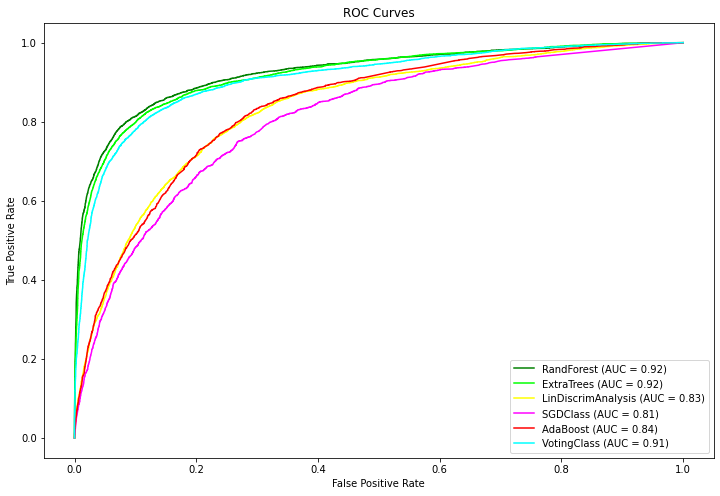

In [ ]:
# Get the predicted probabilities for the test set to look at the ROC curve.

# Add the Voting classifier to the list of classifiers.
# The condition is so this block can be run multiple times in manual debugging.
if grid_search_vot not in classifiers:
    classifiers.append(grid_search_vot)
    names.append('VotingClass')

plt.figure(figsize=(12,8))
an_ax = plt.axes(label='surpress_warning_by_adding_a_label')
an_ax.set_title('ROC Curves')

colours = ['green', 'lime', 'yellow', 'magenta', 'red', 'cyan']

# Return value of metrics.confusion_matrix:
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
print('Confusion Matrix Format:')
print('True  Neg | False Pos')
print('False Neg | True  Pos')
print()

for i in range(len(classifiers)):
    print(names[i])
    print('----')

    prediction = classifiers[i].predict(cargo_test_X)
    cm = metrics.confusion_matrix(cargo_test_y, prediction)
    print('Confusion Matrix:')
    print(cm)
    accuracy = metrics.accuracy_score(cargo_test_y, prediction)
    print('Accuracy: {}'.format(accuracy))
    f1 = metrics.f1_score(cargo_test_y, prediction)
    print('F1 score: {}'.format(f1))
    print()
    
    # The probabilities are expected to only be for the positive class, so need "[:,1]" since "predict_proba" gives both the negative and positive class probabilities.
    proba = classifiers[i].predict_proba(cargo_test_X)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(cargo_test_y, proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=names[i])
    display.plot(an_ax, c=colours[i])

plt.show()

In [ ]:
# Find the estimator with the best score.
best_scores = [c.best_score_ for c in classifiers]
print('All scores: {}'.format(best_scores))

best_index = np.argmax(best_scores)
print('Index of the best score: {}'.format(best_index))
print('Classifier: {}'.format(names[best_index]))
print(classifiers[best_index])

best_estimator = classifiers[best_index].best_estimator_

All scores: [0.672180138114167, 0.659881109384061, 0.42440108434960777, 0.3842744854033163, 0.35660674646283597, 0.5880183569888562]
Index of the best score: 0
Classifier: RandForest
GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'n_estimators': [3, 10, 20, 50, 100, 200, 400]},
                         {'max_depth': [4, 8, 16, 32, 64, 128],
                          'n_estimators': [200, 400]}],
             return_train_score=True, scoring='f1', verbose=100)


In [ ]:
# Train the model while varying the size of the training set to get the learning curve.

train_sizes, train_scores, test_scores = learning_curve(
    best_estimator,
    cargo_train_X,
    cargo_train_y,
    cv=4,
    scoring='f1',
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    random_state=42,
    verbose=100
)

[learning_curve] Training set sizes: [ 7880 15761 23642 31523 39404 47284 55165 63046 70927 78808]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[CV] END ..................., score=(train=0.988, test=0.408) total time=   4.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.986, test=0.500) total time=   9.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.5s remaining:    0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.982, test=0.552) total time=  14.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.6s remaining:    0.0s
[CV] START .....................................................................
[CV] END ....

Text(0, 0.5, 'F1 Score')

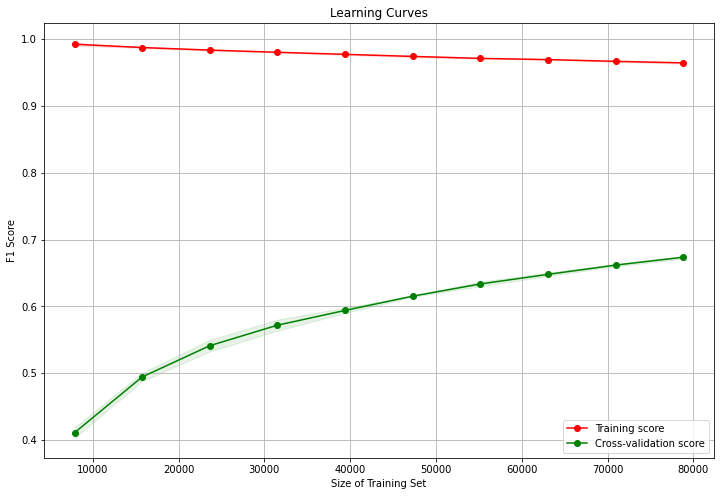

In [ ]:
# Plot the learning curve similar to the example code here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,8))
ax_learn = plt.axes(label='surpress_warning_by_adding_a_label')
ax_learn.set_title('Learning Curves')


ax_learn.grid()
ax_learn.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)
ax_learn.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)
ax_learn.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
ax_learn.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
ax_learn.legend(loc="best")
ax_learn.set_xlabel('Size of Training Set')
ax_learn.set_ylabel('F1 Score')

# Regression

In [ ]:
# Regression to find recovered value

In [ ]:
# Focus on on columns 'DATA_YEAR', 'AGENCY_TYPE_NAME', 'STATE_NAME', 'POPULATION_GROUP_DESC','OFFENSE_NAME', 'VICTIM_TYPE_NAME','LOCATION_NAME','PROP_DESC_NAME','RECOVERED_VALUE' for regression
# Only look at recovered values > 0, as anything under 0 means an error, and anything 0 means it is not recovered

df = master[['DATA_YEAR', 'AGENCY_TYPE_NAME', 'STATE_NAME', 'POPULATION_GROUP_DESC','OFFENSE_NAME', 'VICTIM_TYPE_NAME','LOCATION_NAME','PROP_DESC_NAME','RECOVERED_VALUE']].copy()
df = df[df['RECOVERED_VALUE'] > 0]

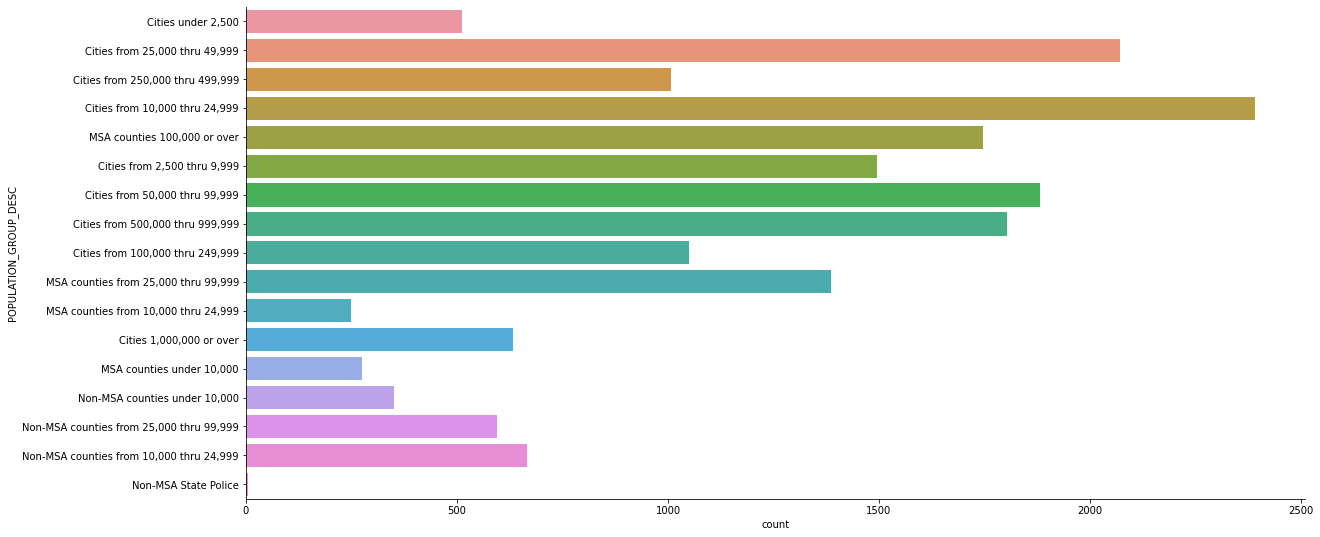

In [ ]:
# data exploration on columns to find trends

import matplotlib.pyplot as plt
import seaborn as sns

# Number of articles that is stolen at a city of specific characteristics 

g = sns.catplot(y = 'POPULATION_GROUP_DESC', kind = "count", data = df)
g.fig.set_size_inches(60,8)

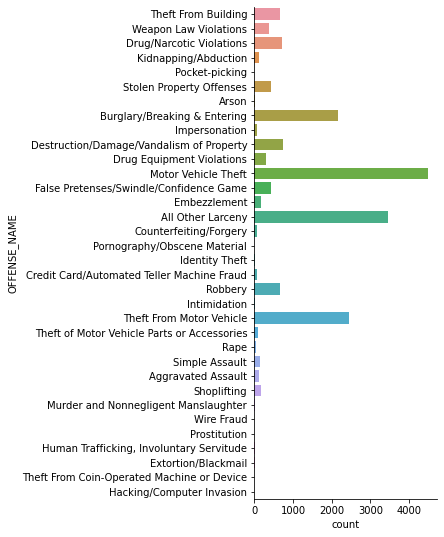

In [ ]:
# Type of theft being committed

h = sns.catplot(y = 'OFFENSE_NAME', kind = "count", data = df)
h.fig.set_size_inches(10,8)

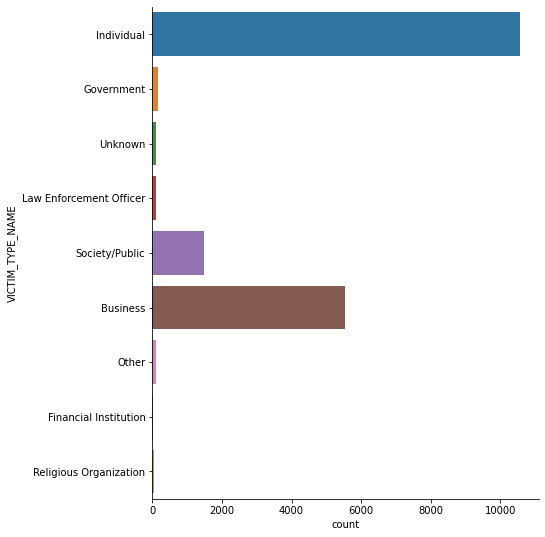

In [ ]:
# Number of articles that is stolen from a certain individual type

i = sns.catplot(y = 'VICTIM_TYPE_NAME', kind = "count", data = df)
i.fig.set_size_inches(10,8)

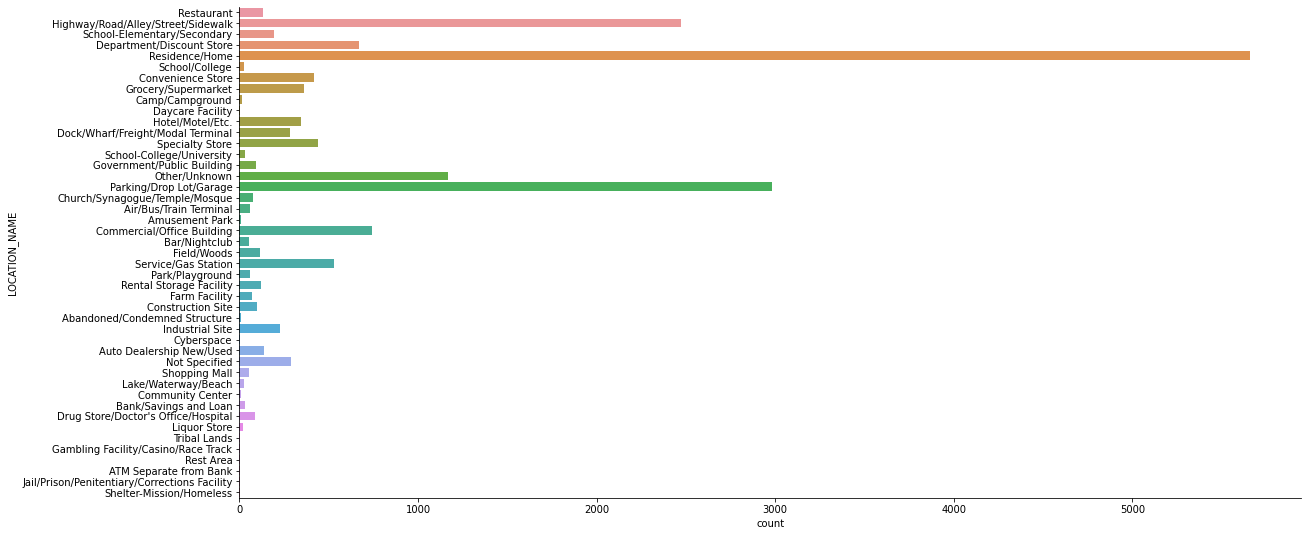

In [ ]:
# Number of articles that is stolen at a certain location

j = sns.catplot(y = 'LOCATION_NAME', kind = "count", data = df)
j.fig.set_size_inches(50,8)

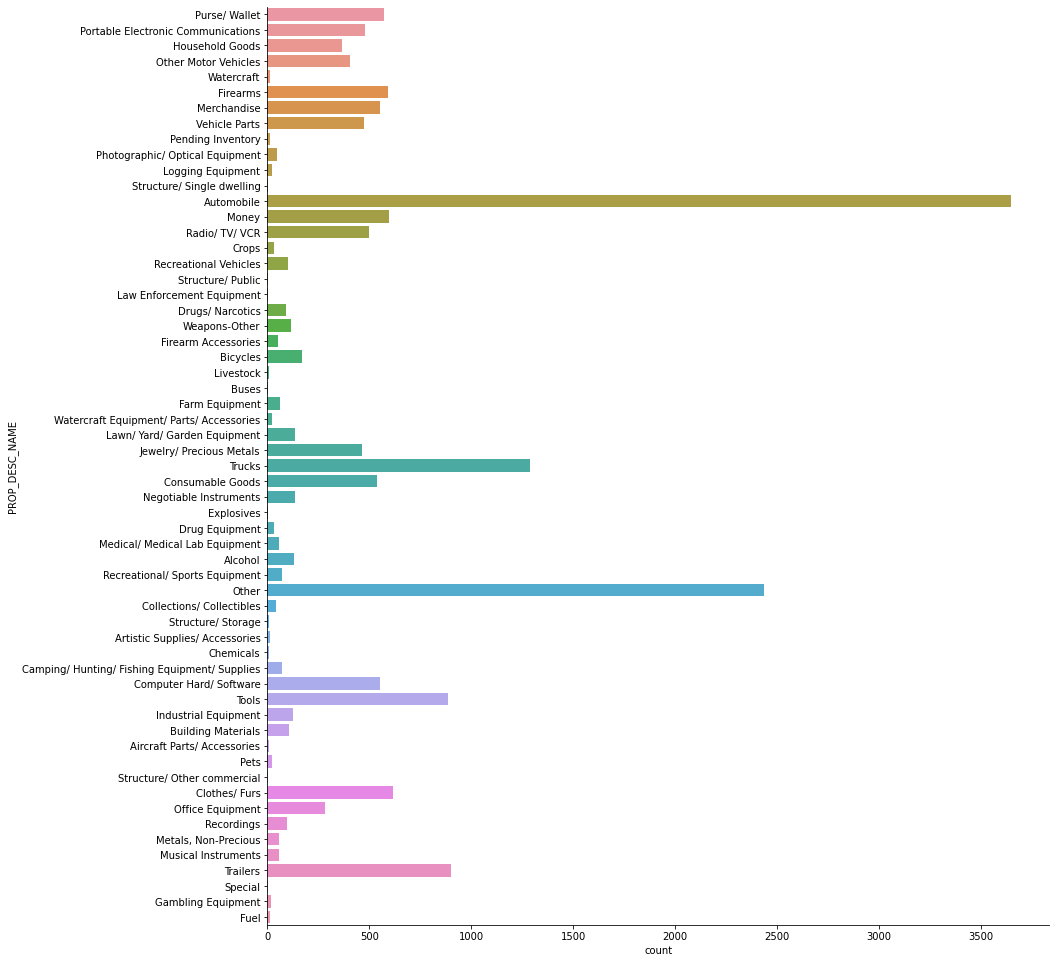

In [ ]:
# Count of articles that is being stolen
j = sns.catplot(y = 'PROP_DESC_NAME', kind = "count", data = df)
j.fig.set_size_inches(50,15)

In [ ]:
# removing all values that show 'others' as they do not provide insight
df.drop(df[df['PROP_DESC_NAME'] == 'Other' ].index, inplace=True)
df.drop(df[df['VICTIM_TYPE_NAME'] == 'Other' ].index, inplace=True)

# convert DATA_YEAR into string

df['DATA_YEAR'] = df['DATA_YEAR'].apply(str)



In [ ]:
# transform all catergorical variables to Dummy Variable

one_hot = pd.get_dummies(df['DATA_YEAR'])
df = df.drop('DATA_YEAR', axis=1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['AGENCY_TYPE_NAME'])
df = df.drop('AGENCY_TYPE_NAME', axis=1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['STATE_NAME'])
df = df.drop('STATE_NAME', axis=1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['POPULATION_GROUP_DESC'])
df = df.drop('POPULATION_GROUP_DESC', axis=1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['OFFENSE_NAME'])
df = df.drop('OFFENSE_NAME', axis=1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['VICTIM_TYPE_NAME'])
df = df.drop('VICTIM_TYPE_NAME', axis=1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['LOCATION_NAME'])
df = df.drop('LOCATION_NAME', axis=1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['PROP_DESC_NAME'])
df = df.drop('PROP_DESC_NAME', axis=1)
df = df.join(one_hot)

In [ ]:
df.head()

,RECOVERED_VALUE,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,City,County,Other,Other State Agency,State Police,Tribal,University or College,Alabama,Alaska,Arizona,Arkansas,Colorado,Connecticut,Delaware,Florida,Georgia,Idaho,Indiana,Kentucky,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,...,Firearm Accessories,Firearms,Fuel,Gambling Equipment,Household Goods,Industrial Equipment,Jewelry/ Precious Metals,Law Enforcement Equipment,Lawn/ Yard/ Garden Equipment,Livestock,Logging Equipment,Medical/ Medical Lab Equipment,Merchandise,"Metals, Non-Precious",Money,Musical Instruments,Negotiable Instruments,Office Equipment,Other Motor Vehicles,Pending Inventory,Pets,Photographic/ Optical Equipment,Portable Electronic Communications,Purse/ Wallet,Radio/ TV/ VCR,Recordings,Recreational Vehicles,Recreational/ Sports Equipment,Special,Structure/ Other commercial,Structure/ Public,Structure/ Single dwelling,Structure/ Storage,Tools,Trailers,Trucks,Vehicle Parts,Watercraft,Watercraft Equipment/ Parts/ Accessories,Weapons-Other
10,104.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60,10.0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
63,1000.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91,500.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107,2.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# splitting data for training

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)

target = 'RECOVERED_VALUE'
features = list(train_set.columns)
features = [f for f in features if f!=target]

X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

In [ ]:
# baseline result using linear regression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), X_tr, y_tr, scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [2.12955170e+15 9.12532076e+15 1.04584219e+15 5.18586526e+14]
Mean: 3204825293899335.5


In [ ]:
# feature selection method 1: using selectKBest using mutual info regression

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression


iteration = []
score = []

for i in range(50):

  X_optimal = SelectKBest(mutual_info_regression, k=i).fit_transform(X_tr, y_tr.values.ravel())

  lin_scores = cross_val_score(LinearRegression(), X_optimal, y_tr, scoring="neg_mean_squared_error", cv=4)
  lin_rmse_scores = np.sqrt(-lin_scores)
  score.append(lin_rmse_scores.mean())
  iteration.append(i)



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_base.py:95: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 4.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py", line 663, in fit
    X, y, accept_sparse=accep

In [ ]:
# showing results from selectKbest using RMSE as a decision factor

de = {'Number of Features': iteration, 'RMSE': score}
RMSE_analysis = pd.DataFrame(data=de)
RMSE_analysis = RMSE_analysis.sort_values('RMSE')
RMSE_analysis

# best K = 47

,Number of Features,RMSE
47,47,41425.386450
46,46,41441.862755
49,49,41451.007770
34,34,41456.160242
41,41,41465.195648
44,44,41469.223149
48,48,41470.280277
45,45,41471.387930
42,42,41476.147865
35,35,41477.422138


In [ ]:
# feature selection method 2: Random Forest Classifier 

from sklearn.ensemble import RandomForestClassifier

#part 1 : fitting the model with Random Forest and getting the scores for each feature
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes = 16)
rnd_clf.fit(X_tr, y_tr.values.ravel())


name = []
score = []
for x, y in zip(features, rnd_clf.feature_importances_):
  name.append(x)
  score.append(y)

#part 2 : passing different numbers of features to find the best number results using RMSE score

iteration_forest = []
score_forest = []

for i in range(50): 

  d = {'Features_in_Data': name, 'Feature_Importance': score}
  feature_analysis = pd.DataFrame(data=d)
  feature_analysis = feature_analysis.sort_values('Feature_Importance', ascending=False)
  feature_analysis_top = feature_analysis.head(i).copy()



  feature_list = feature_analysis_top['Features_in_Data'].tolist()
  X_chosen = X_tr[feature_list]
  X_chosen

  lin_scores = cross_val_score(LinearRegression(), X_chosen, y_tr, scoring="neg_mean_squared_error", cv=4)
  lin_rmse_scores = np.sqrt(-lin_scores)

  score_forest.append(lin_rmse_scores.mean())
  iteration_forest.append(i)

de = {'Number of Features': iteration_forest, 'RMSE': score_forest}
RMSE_analysis_for = pd.DataFrame(data=de)
RMSE_analysis_for = RMSE_analysis_for.sort_values('RMSE')
RMSE_analysis_for




/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 4.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py", line 663, in fit
    X, y, accept_sparse=accept_sparse, y_numeric=True, multi_output=True
  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 576, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/loc

,Number of Features,RMSE
0,0,41451.007770
74,23,41451.007770
73,22,41451.007770
72,21,41451.007770
71,20,41451.007770
...,...,...
106,4,43275.614801
105,3,43288.206431
104,2,43891.275192
103,1,43929.702510


In [ ]:
# From the 2 methods, selectKbest provided the lowest RMSE score at k = 47
# Start fitting Regression models
# Try fitting SVM using original dataset (without feature selection)

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


lin_scores = cross_val_score(SVR(), X_tr, np.ravel(y_tr), scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [51147.49628978 49241.92186477 38113.04248007 42215.01505778]
Mean: 45179.3689231009


In [ ]:
# Feature selection on X_tr and X_te

X_new = SelectKBest(mutual_info_regression, k=47).fit_transform(X_tr, y_tr.values.ravel())
Xtest_new = SelectKBest(mutual_info_regression, k=47).fit_transform(X_te, y_te.values.ravel())



In [ ]:
# Linear Regression performance on selectKbest dataset

linear_regressor = LinearRegression().fit(X_new,y_tr)

y_pred_lin = linear_regressor.predict(Xtest_new)

rms = np.sqrt(mean_squared_error(y_te, y_pred_lin))

rms

74756.12483653163

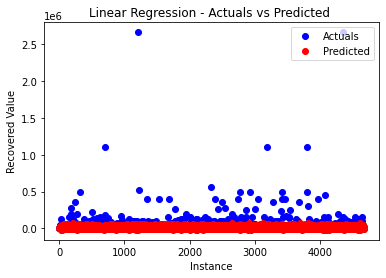

In [ ]:
# Plotting Linear regression prediction vs actuals after feature selection

y_te = y_te.reset_index(drop=True)

plt.plot(y_te,  'ro', color = "blue", label = "Actuals")
plt.plot(y_pred_lin,  'ro', color = "red", label = "Predicted")
plt.xlabel("Instance")
plt.ylabel("Recovered Value")
plt.title("Linear Regression - Actuals vs Predicted ")
plt.legend (loc="upper right")

In [ ]:
# Applying SVR to feature selected X-train using k = 47

lin_scores = cross_val_score(SVR(), X_new, np.ravel(y_tr), scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [51141.13826156 49234.96191211 38104.80504195 42207.13351247]
Mean: 45172.009682020245


In [ ]:
# Try to see SVR hypertuning can improve RMSE results

C_vals = [100,1000,3000000]
gamma_vals = [0.02, 0.03,0.04] 

param_grid = [{'C':C_vals, 'gamma':gamma_vals}]
grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,scoring='neg_mean_squared_error')
grid_search_rbf.fit(X_new, np.ravel(y_tr))

GridSearchCV(cv=3, estimator=SVR(),
             param_grid=[{'C': [100, 1000, 3000000],
                          'gamma': [0.02, 0.03, 0.04]}],
             scoring='neg_mean_squared_error')

In [ ]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 3000000, 'gamma': 0.04}
40503.589187556216


In [ ]:
# retraining SVR Model with best params
# SVR performance on selectKbest dataset

svm_reg = SVR(kernel = "poly", C= 3000000, gamma= 0.04)
svm_reg.fit(X_new, np.ravel(y_tr))

y_pred = svm_reg.predict(Xtest_new)

rms = np.sqrt(mean_squared_error(y_te, y_pred))
rms

72887.2095691016

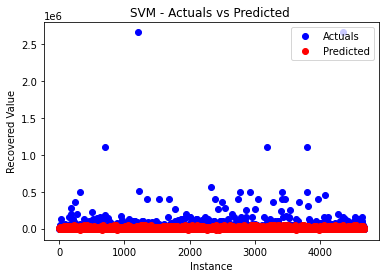

In [ ]:
#SVM plot

plt.plot(y_te,  'ro', color = "blue", label = "Actuals")
plt.plot(y_pred,  'ro', color = "red", label = "Predicted")
plt.xlabel("Instance")
plt.ylabel("Recovered Value")
plt.title("SVM - Actuals vs Predicted ")
plt.legend (loc="upper right")

In [ ]:
# Try RandomForestRegressor to see performance

from sklearn.ensemble import RandomForestRegressor

param_grid_for = {'n_estimators': [3, 10, 20, 50, 100, 200]}
forest = RandomForestRegressor(random_state=42)


grid_search_for = GridSearchCV(forest, param_grid_for, scoring= 'neg_mean_squared_error')
grid_search_for.fit(X_new, np.ravel(y_tr))

grid_search_for.best_estimator_

RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
reg_for = RandomForestRegressor(n_estimators=200, random_state=42)
reg_for.fit(X_new, np.ravel(y_tr))

y_pred_for = reg_for.predict(Xtest_new)
rms = np.sqrt(mean_squared_error(y_te, y_pred_for))
rms

88434.57669291791

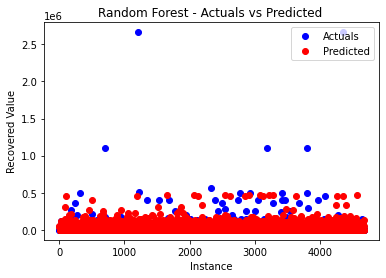

In [ ]:
#Random Forest plot

plt.plot(y_te,  'ro', color = "blue", label = "Actuals")
plt.plot(y_pred_for,  'ro', color = "red", label = "Predicted")
plt.xlabel("Instance")
plt.ylabel("Recovered Value")
plt.title("Random Forest - Actuals vs Predicted ")
plt.legend (loc="upper right")

In [ ]:
# Try Gradient Boosting

# not using adaboost as there is a lot of irrelevant features

import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_tr, y_tr.values.ravel())

y_pred_gradient = xgb_reg.predict(X_te)

rms = np.sqrt(mean_squared_error(y_te, y_pred_gradient))
rms


[04:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


64965.73694111657

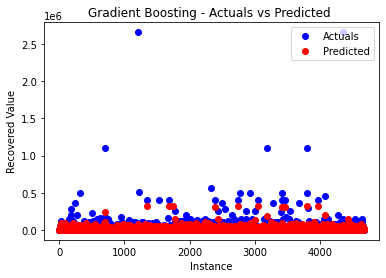

In [ ]:
#Gradient Boosting Plot

plt.plot(y_te,  'ro', color = "blue", label = "Actuals")
plt.plot(y_pred_gradient,  'ro', color = "red", label = "Predicted")
plt.xlabel("Instance")
plt.ylabel("Recovered Value")
plt.title("Gradient Boosting - Actuals vs Predicted ")
plt.legend (loc="upper right")

In [ ]:
# Gradient Boosting Learning Graph
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    xgb_reg,
    X_tr,
    y_tr,
    scoring = 'neg_mean_squared_error',
    cv=4,
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    random_state=42,
    verbose=100
)

[learning_curve] Training set sizes: [ 818 1637 2456 3275 4094 4913 5732 6551 7370 8189]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[04:19:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END , score=(train=-193247156.831, test=-2212203063.476) total time=   0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[CV] START .....................................................................
[04:19:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END , score=(train=-403667829.503, test=-2331631820.323) total time=   0.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[CV] START .....................................................................
[04:19:02] 

Text(0, 0.5, 'Neg_Mean_squared_error')

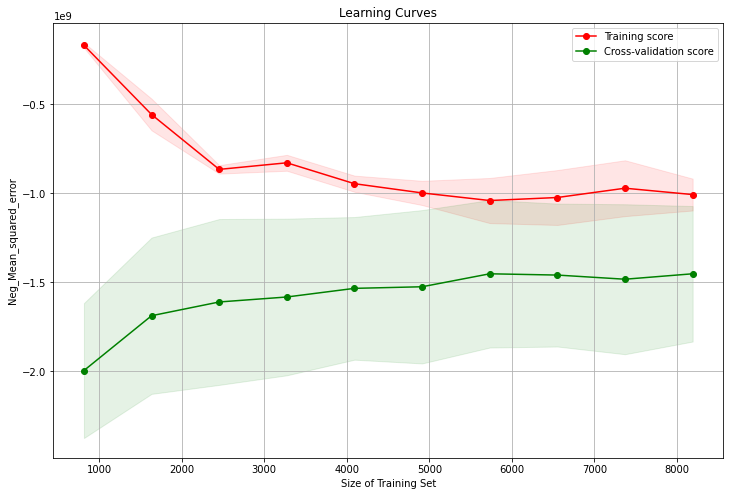

In [ ]:
# Plotting learning graph
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,8))
ax_learn = plt.axes(label='surpress_warning_by_adding_a_label')
ax_learn.set_title('Learning Curves')


ax_learn.grid()
ax_learn.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)
ax_learn.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)
ax_learn.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
ax_learn.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
ax_learn.legend(loc="best")
ax_learn.set_xlabel('Size of Training Set')
ax_learn.set_ylabel('Neg_Mean_squared_error')